<a href="https://colab.research.google.com/github/MerArch/Forecast_gradBoosting/blob/main/GRADIENTBOOST_NEURALN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient boosting Algorithms
* XGBOOST
* CATBOOST
* LGBM

# Neural Network
* LSTM

In [ ]:
import warnings

!pip install numpy>=1.22
warnings.filterwarnings("ignore")

In [ ]:
!pip install ta
warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=c0340ccc1ffea08a498f85356686f51a5852be59012f6ea1958ed2ba40800588
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
!pip install catboost


In [ ]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install --upgrade pyarrow
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 2.3 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 15.0.2
    Uninstalling pyarrow-15.0.2:
      Successfully uninstalled pyarrow-15.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but yo

In [ ]:
import os
import glob
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import scipy as sc

from sklearn.model_selection import KFold

from sklearn import set_config
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
# the below is the measures on which the model will be evaluated and compared
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

# the below are the gradient boost models that will be trained using the given data
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import catboost as cbt
import joblib
#
from sklearn.model_selection import KFold
# import optuna
import ta
#
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import joblib
# the below are for visualisations to support analytics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'white', palette = 'viridis')
# pal
pal_col = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.options.mode.chained_assignment = None
set_config(transform_output = 'pandas')


In [ ]:
df_train = pd.read_csv('/kaggle/input/datareqdstkpred/optiver-trading-at-the-close/train.csv')
# df_test = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/test.csv')
test_set = pd.read_csv('/kaggle/input/datareqdstkpred/test.csv/test.csv')

In [ ]:
df_train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [ ]:
test_set.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.0,-2.310276,26290,478_0_0
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.0,-12.850165,26290,478_0_1
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.0,-0.439882,26290,478_0_2
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.0,7.259846,26290,478_0_3
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.0,4.780292,26290,478_0_4


In [ ]:
df_train.tail()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198
5237979,199,480,540,1884285.71,-1,1.002129,24073677.32,1.000859,1.001494,1.002129,250081.44,1.002447,300167.56,1.002274,-6.530285,26454,480_540_199


In [ ]:
test_set.tail()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
32995,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,-0.510216,26454,480_540_195
32996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,2.089739,26454,480_540_196
32997,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,-0.529885,26454,480_540_197
32998,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,3.579855,26454,480_540_198
32999,199,480,540,1884285.71,-1,1.002129,24073677.32,1.000859,1.001494,1.002129,250081.44,1.002447,300167.56,1.002274,1.900196,26454,480_540_199


In [ ]:
df_train.shape

(5237980, 17)

In [ ]:
test_set.shape

(33000, 17)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [ ]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   stock_id                 33000 non-null  int64  
 1   date_id                  33000 non-null  int64  
 2   seconds_in_bucket        33000 non-null  int64  
 3   imbalance_size           33000 non-null  float64
 4   imbalance_buy_sell_flag  33000 non-null  int64  
 5   reference_price          33000 non-null  float64
 6   matched_size             33000 non-null  float64
 7   far_price                14771 non-null  float64
 8   near_price               15000 non-null  float64
 9   bid_price                33000 non-null  float64
 10  bid_size                 33000 non-null  float64
 11  ask_price                33000 non-null  float64
 12  ask_size                 33000 non-null  float64
 13  wap                      33000 non-null  float64
 14  target                

# Test data EDA

### check for any missing values in rows and columns

In [ ]:
# Check for missing values in columns
missing_columns = test_set.isnull().sum()
print("Missing values in columns:")
print(missing_columns)

# Check for missing values in rows
missing_rows = test_set.isnull().any(axis=1).sum()
print("\nNumber of rows with missing values:", missing_rows)


Missing values in columns:
stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price                0
matched_size                   0
far_price                  18229
near_price                 18000
bid_price                      0
bid_size                       0
ask_price                      0
ask_size                       0
wap                            0
target                       108
time_id                        0
row_id                         0
dtype: int64

Number of rows with missing values: 18229


### Drop the columns with missing columns and has no value add to the model testing

In [ ]:
# Drop the columns with missing values
df_cleaned = test_set.drop(columns=['far_price', 'near_price'])

# Display the first few rows of the cleaned DataFrame
print(df_cleaned.head())

   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0      478                  0      3753451.43   
1         1      478                  0       985977.11   
2         2      478                  0       599128.74   
3         3      478                  0      2872317.54   
4         4      478                  0       740059.14   

   imbalance_buy_sell_flag  reference_price  matched_size  bid_price  \
0                       -1         0.999875   11548975.43   0.999875   
1                       -1         1.000245    3850033.97   0.999940   
2                        1         1.000584    4359198.25   0.999918   
3                       -1         0.999802   27129551.64   0.999705   
4                       -1         0.999886    8880890.78   0.999720   

   bid_size  ask_price  ask_size  wap     target  time_id   row_id  
0  22940.00   1.000050   9177.60  1.0  -2.310276    26290  478_0_0  
1   1967.90   1.000601  19692.00  1.0 -12.850165    26290  478_0_1  
2   4

In [ ]:
def record_overview(series, num_records=10):
    uni_val = series.unique()
    uni_val.sort()  # Sort in place if sorting is necessary
    print(uni_val[:num_records])
    print(uni_val[-num_records:])

record_overview(df_cleaned["stock_id"])
record_overview(df_cleaned["date_id"])
record_overview(df_cleaned['seconds_in_bucket'])

[0 1 2 3 4 5 6 7 8 9]
[190 191 192 193 194 195 196 197 198 199]
[478 479 480]
[478 479 480]
[ 0 10 20 30 40 50 60 70 80 90]
[450 460 470 480 490 500 510 520 530 540]


In [ ]:
train_vol = df_train.dropna(subset=["target"])
train_vol.reset_index(drop=True, inplace=True)
trn_shape= df_train.shape

In [ ]:
print(trn_shape)

(5237980, 17)



The record_overview function is designed to provide a summary overview of unique values in a given series. It takes two parameters: series, which represents the input series whose unique values are to be examined, and num_records, which specifies the number of unique values to display for both the beginning and end of the series.

In [ ]:

def record_overview(series, num_records=10):
    uni_val = series.unique()
    uni_val.sort()
    print(uni_val[:num_records])
    print(uni_val[-num_records:])

record_overview(train_vol["stock_id"])
record_overview(train_vol["date_id"])
record_overview(train_vol['seconds_in_bucket'])

[0 1 2 3 4 5 6 7 8 9]
[190 191 192 193 194 195 196 197 198 199]
[0 1 2 3 4 5 6 7 8 9]
[471 472 473 474 475 476 477 478 479 480]
[ 0 10 20 30 40 50 60 70 80 90]
[450 460 470 480 490 500 510 520 530 540]


In [ ]:
tr_count = train_vol.isnull().sum()
tr_percent = (train_vol.isnull().sum()) / len(train_vol)
tr_mv_df = pd.DataFrame({'count': tr_count, 'percentage': tr_percent})
tr_mv_df

,count,percentage
stock_id,0,0.000000
date_id,0,0.000000
seconds_in_bucket,0,0.000000
imbalance_size,132,0.000025
imbalance_buy_sell_flag,0,0.000000
reference_price,132,0.000025
matched_size,132,0.000025
far_price,2894254,0.552561
near_price,2857092,0.545466
bid_price,132,0.000025


In [ ]:
def feature_attributes(df):
    answer = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'nunique': df.nunique(),
        'null_count': df.isna().sum(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 4),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return answer

feature_attributes(train_vol)

,unique,nunique,null_count,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,0,0.0000,0,158,199,int64
date_id,False,481,0,0.0000,0,361,480,int64
seconds_in_bucket,False,55,0,0.0000,0,500,540,int64
imbalance_size,False,2971863,132,0.0025,3180602.69,86351.31,1884285.71,float64
imbalance_buy_sell_flag,False,3,0,0.0000,1,-1,-1,int64
reference_price,False,28741,132,0.0025,0.999812,1.002888,1.002129,float64
matched_size,False,2948862,132,0.0025,13380276.64,4418577.58,24073677.32,float64
far_price,False,95739,2894254,55.2561,NaN,1.002888,1.000859,float64
near_price,False,84625,2857092,54.5466,NaN,1.002888,1.001494,float64
bid_price,False,28313,132,0.0025,0.999812,1.002888,1.002129,float64


In [ ]:
def feat_att(df):
    answer = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'nunique': df.nunique(),
        'null_count': df.isna().sum(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 4),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return answer

feat_att(df_cleaned)

,unique,nunique,null_count,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,0,0.0000,0,52,199,int64
date_id,False,3,0,0.0000,478,480,480,int64
seconds_in_bucket,False,55,0,0.0000,0,540,540,int64
imbalance_size,False,20327,0,0.0000,3753451.43,44552.98,1884285.71,float64
imbalance_buy_sell_flag,False,3,0,0.0000,-1,-1,-1,int64
reference_price,False,5733,0,0.0000,0.999875,0.999533,1.002129,float64
matched_size,False,18595,0,0.0000,11548975.43,5333447.78,24073677.32,float64
bid_price,False,5464,0,0.0000,0.999875,0.999533,1.002129,float64
bid_size,False,31160,0,0.0000,22940.0,52584.84,250081.44,float64
ask_price,False,5478,0,0.0000,1.00005,0.999739,1.002447,float64


# # 1-2. Exploratory Data Analysis (EDA)

In [ ]:
train_vol.columns


Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

In [ ]:
df_cleaned.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'target',
       'time_id', 'row_id'],
      dtype='object')

In [ ]:
test_set.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

Categorising helps the boosting alogorithms to perform better.

In [ ]:
# grouping features as categorical and numerical for test data

categorical_test = ['imbalance_buy_sell_flag', 'stock_id']
numerical_test = [ 'imbalance_size','reference_price', 'matched_size','far_price',
             'near_price', 'bid_price', 'bid_size', 'ask_price',
                'ask_size', 'wap']

In [ ]:
# grouping features as categorical and numerical
categorical = ['imbalance_buy_sell_flag', 'stock_id']
numerical = [ 'imbalance_size','reference_price', 'matched_size','far_price',
             'near_price', 'bid_price', 'bid_size', 'ask_price',
                'ask_size', 'wap']

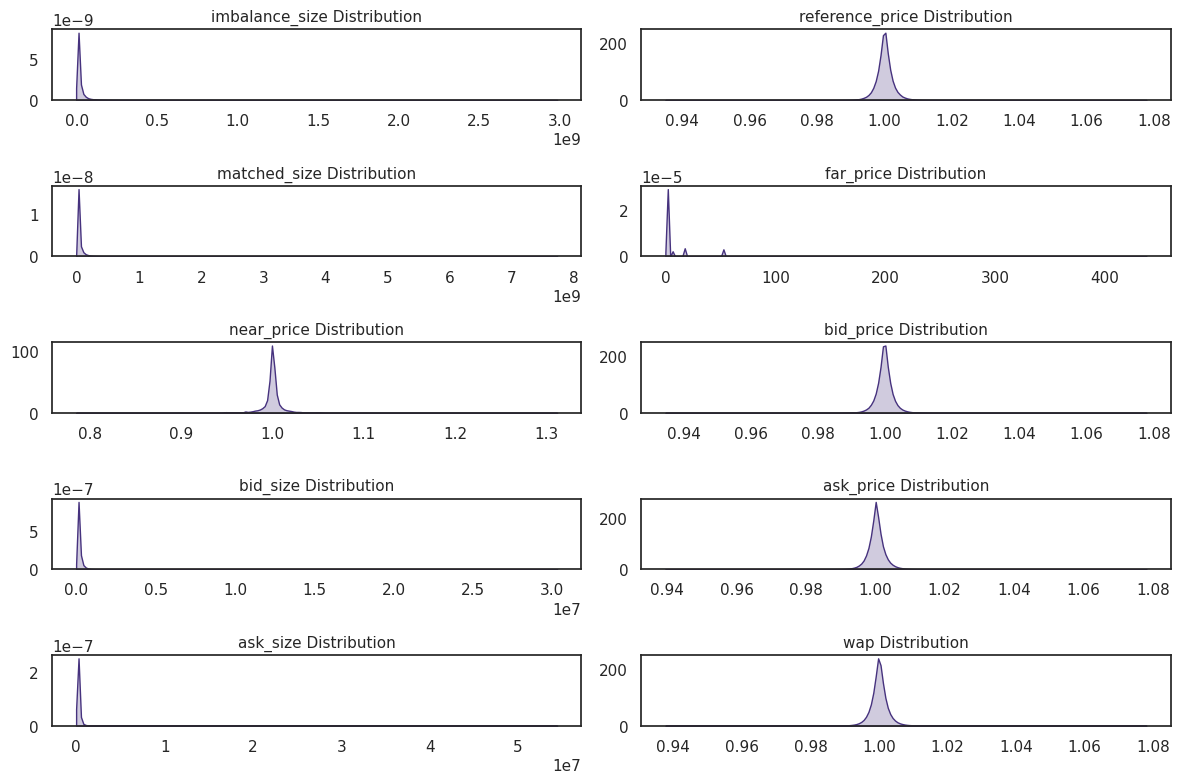

In [ ]:
# histogram

fg, axs = plt.subplots(5, 2, figsize=(12, 8))

for i, col_name in enumerate(numerical):
    row, col = divmod(i, 2)
    sns.kdeplot(train_vol[col_name], ax=axs[row, col], fill=True)
    axs[row, col].set_title(f'{col_name} Distribution', size=11)
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel('')

plt.tight_layout()


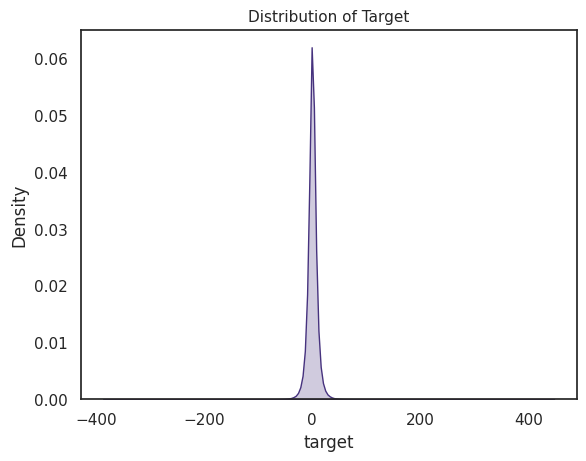

In [ ]:
# target distribution check
sns.kdeplot(train_vol.target, fill= True)
plt.title('Distribution of Target', size = 11)
plt.show()

   imbalance_buy_sell_flag     count
0                       -1  0.397936
1                        1  0.386040
2                        0  0.216023
--------------------------------------------------------


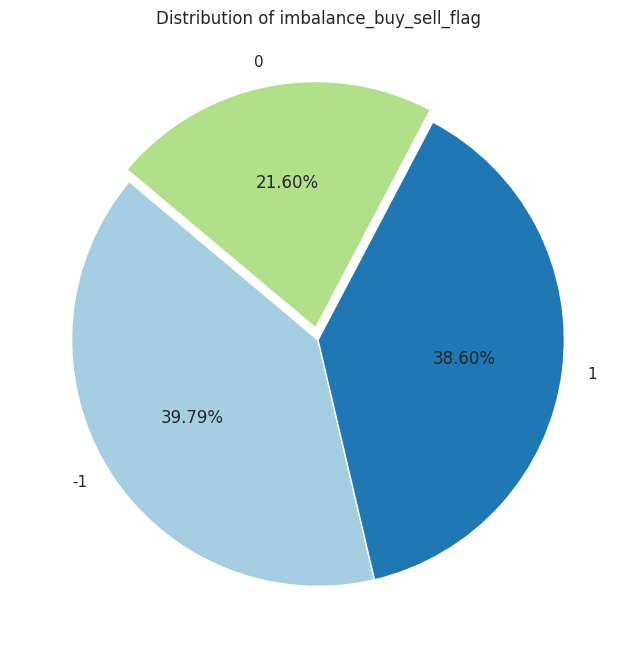

In [ ]:
cat_df = pd.DataFrame(train_vol['imbalance_buy_sell_flag'].value_counts() / train_vol['imbalance_buy_sell_flag'].count())

cat_df.reset_index(inplace=True)

cat_df.columns = ['imbalance_buy_sell_flag', 'count']

print(cat_df)
print('--------------------------------------------------------')

colors = plt.cm.Paired(range(len(cat_df)))

plt.figure(figsize=(8, 8))

explist = [0.05 if i == cat_df['count'].idxmin() else 0 for i in range(cat_df.shape[0])]

plt.pie(x=cat_df['count'],
        explode=explist,
        labels=cat_df['imbalance_buy_sell_flag'],
        autopct='%.2f%%',
        colors=colors,
        startangle=140)

plt.title('Distribution of imbalance_buy_sell_flag')

plt.show()

<Axes: >

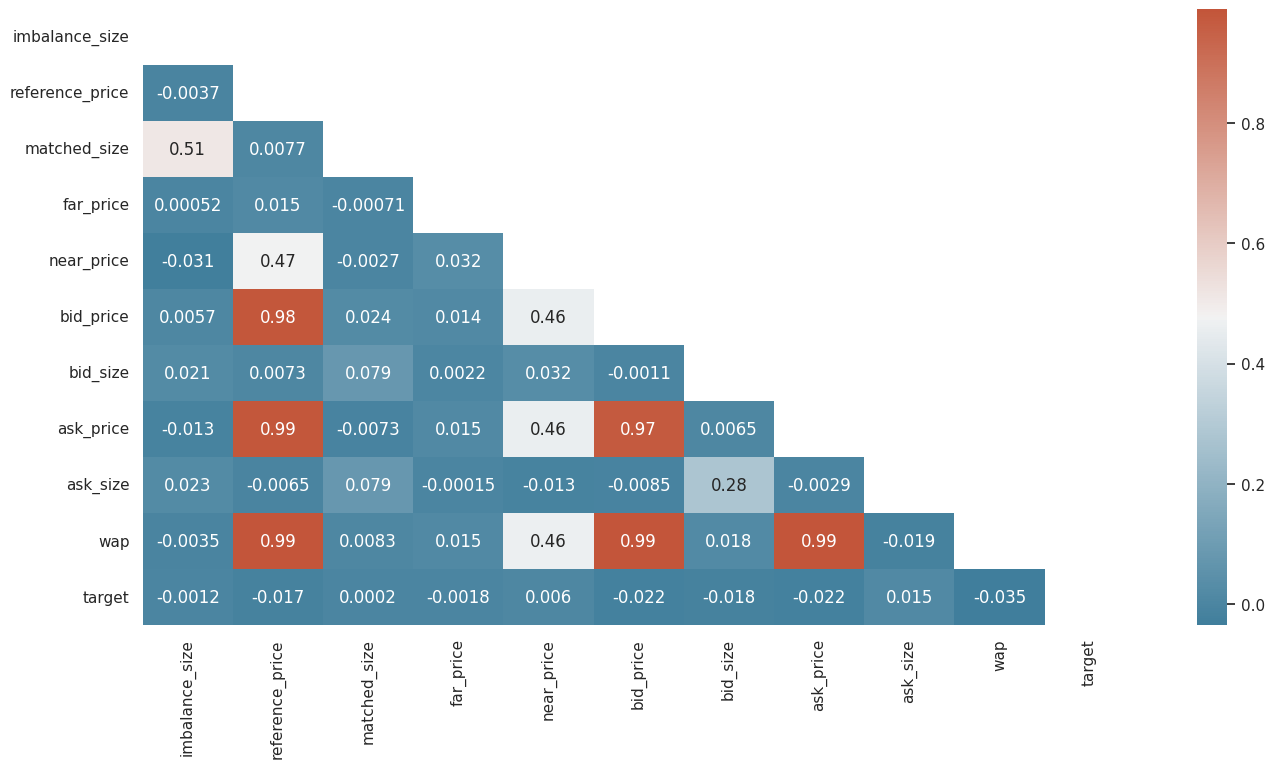

In [ ]:
# correlation plot
corr_feat = numerical + ['target']
correlation = train_vol[corr_feat].corr()

# determine size of the plot
fig, ax = plt.subplots(figsize = (16, 8))

# create a mask for upper traingle
masking = np.triu(np.ones_like(correlation, dtype = bool))

# A custom diverging colormap is configured
map = sns.diverging_palette(230, 20, as_cmap = True)

# execute the heatmap
sns.heatmap(correlation, annot = True, mask = masking, cmap = map)

In [ ]:
tr_count = train_vol.isnull().sum()
tr_percent = (train_vol.isnull().sum()) / len(train_vol)
mv_df = pd.DataFrame({'count': tr_count, 'percentage': tr_percent})
mv_df

,count,percentage
stock_id,0,0.000000
date_id,0,0.000000
seconds_in_bucket,0,0.000000
imbalance_size,132,0.000025
imbalance_buy_sell_flag,0,0.000000
reference_price,132,0.000025
matched_size,132,0.000025
far_price,2894254,0.552561
near_price,2857092,0.545466
bid_price,132,0.000025


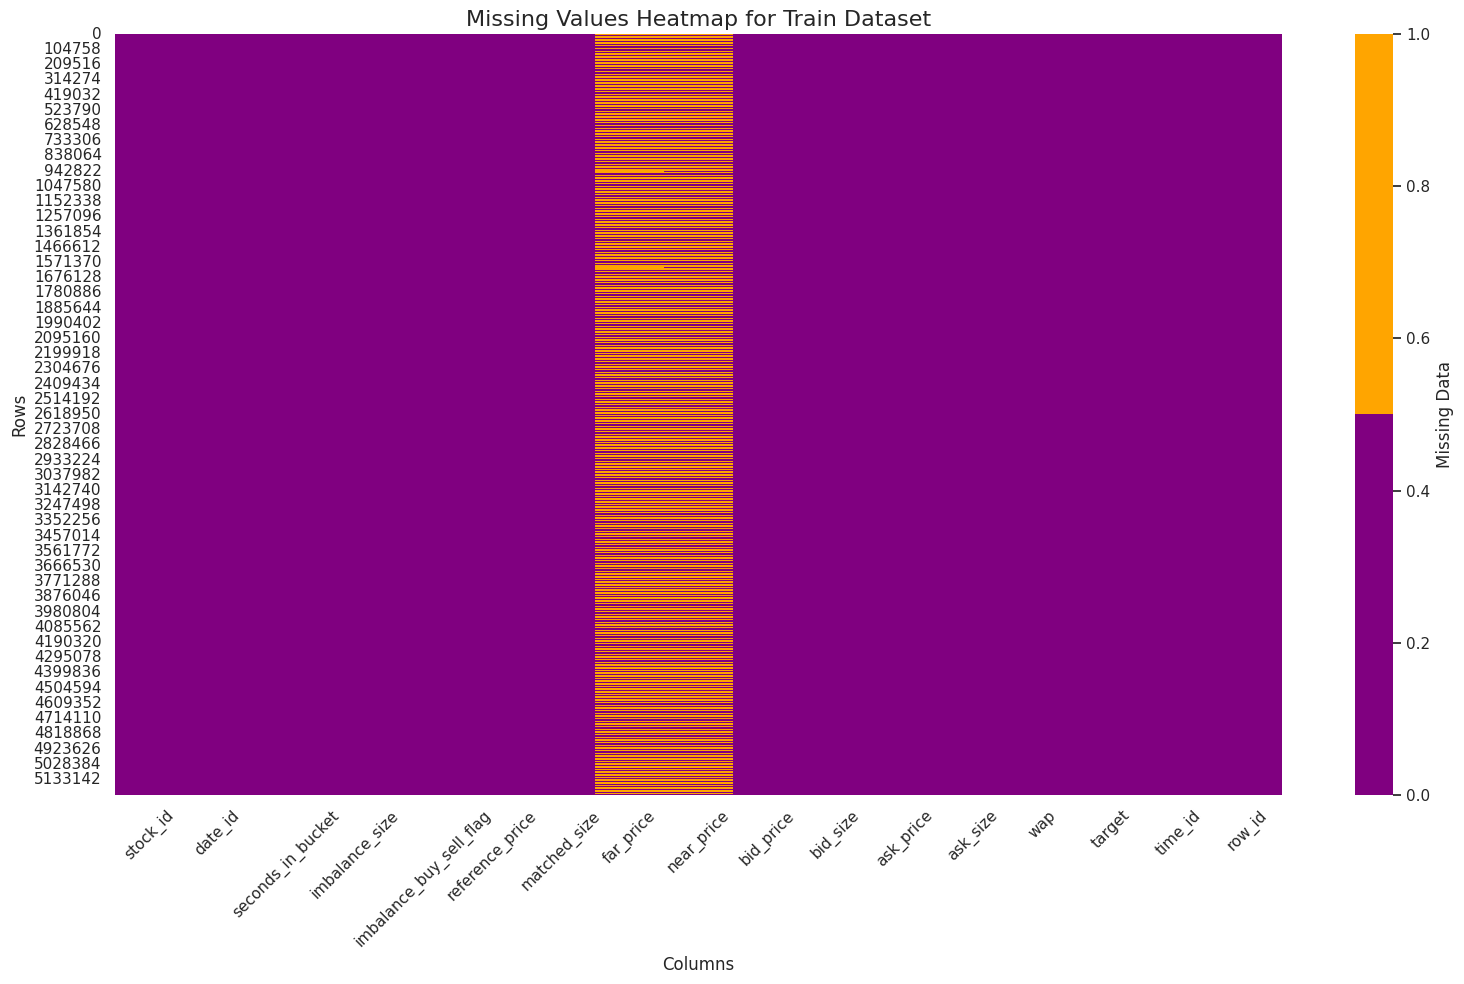

In [ ]:
plt.figure(figsize=(16, 10))
select_color = ['#800080', '#FFA500']  # purple for missing values, orange for non-missing.
sns.heatmap(train_vol.isnull(), cmap=sns.color_palette(select_color), cbar_kws={'label': 'Missing Data'})

plt.title('Missing Values Heatmap for Train Dataset', fontsize=16)
plt.xlabel('Columns')
plt.ylabel('Rows')

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()

plt.show()

<Axes: >

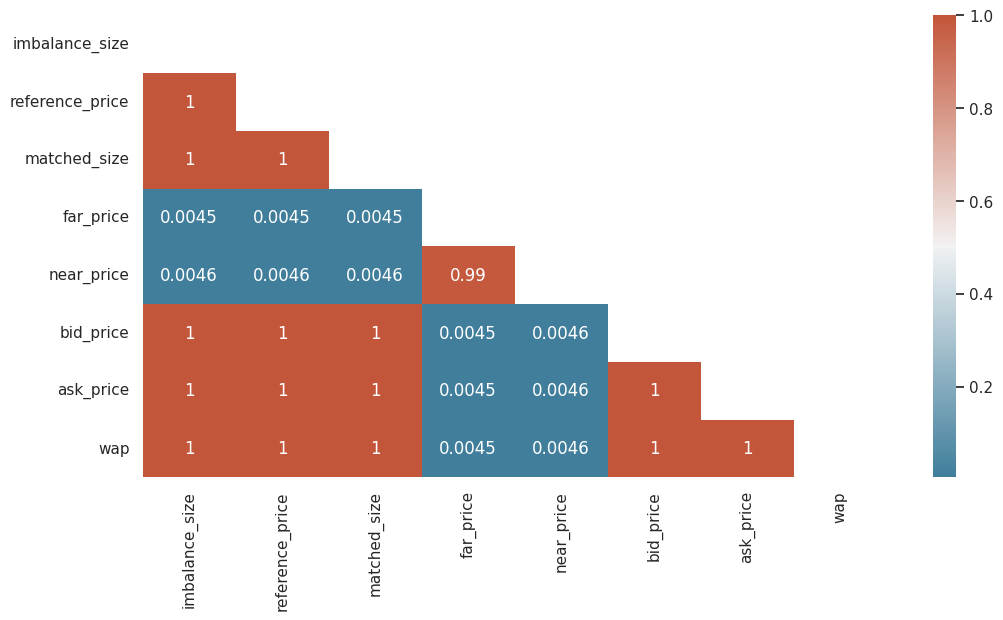

In [ ]:
corr_1 = train_vol.loc[:, train_vol.isnull().any()].isnull().corr()

fig, ax = plt.subplots(figsize = (12, 6))

# Generate a mask for upper traingle
masked = np.triu(np.ones_like(corr_1, dtype = bool))

# Configure a custom diverging colormap
cmapg = sns.diverging_palette(230, 20, as_cmap = True)

# Draw the heatmap
sns.heatmap(corr_1, annot = True, mask = masked, cmap = cmapg)

In [ ]:
missing_values = train_vol[['far_price', 'near_price']].isnull()

# To find the number of times both 'near_price' and 'far_price' are missing simulteneously
missing_simul = missing_values.all(axis=1).sum()

print(f"The 'far_price' and 'near_price' features are both missing at the same time in {missing_simul} cases.")

The 'far_price' and 'near_price' features are both missing at the same time in 2857092 cases.


In [ ]:
missing_values = test_set[['far_price', 'near_price']].isnull()

# To find the number of times both 'near_price' and 'far_price' are missing simulteneously
missing_simul = missing_values.all(axis=1).sum()

print(f"The 'far_price' and 'near_price' features are both missing at the same time in {missing_simul} cases.")

The 'far_price' and 'near_price' features are both missing at the same time in 18000 cases.


In [ ]:
# checking for the NA price values by second for TEST data
def total_nan_tst(group):
    return group.isnull().sum()

grpnan = test_set.groupby(
            pd.cut(test_set['seconds_in_bucket'], range(0,541, 10))).apply(total_nan_tst).drop('seconds_in_bucket', axis=1).reset_index()

grpnan[['seconds_in_bucket','far_price', 'near_price']]

,seconds_in_bucket,far_price,near_price
0,"(0, 10]",600,600
1,"(10, 20]",600,600
2,"(20, 30]",600,600
3,"(30, 40]",600,600
4,"(40, 50]",600,600
5,"(50, 60]",600,600
6,"(60, 70]",600,600
7,"(70, 80]",600,600
8,"(80, 90]",600,600
9,"(90, 100]",600,600


In [ ]:
# checking for the NA price values by second
def total_nan(group):
    return group.isnull().sum()

grpnan = train_vol.groupby(
            pd.cut(train_vol['seconds_in_bucket'], range(0,541, 10))).apply(total_nan).drop('seconds_in_bucket', axis=1).reset_index()

grpnan[['seconds_in_bucket','far_price', 'near_price']]

,seconds_in_bucket,far_price,near_price
0,"(0, 10]",95234,95234
1,"(10, 20]",95234,95234
2,"(20, 30]",95234,95234
3,"(30, 40]",95234,95234
4,"(40, 50]",95234,95234
5,"(50, 60]",95234,95234
6,"(60, 70]",95234,95234
7,"(70, 80]",95234,95234
8,"(80, 90]",95234,95234
9,"(90, 100]",95234,95234


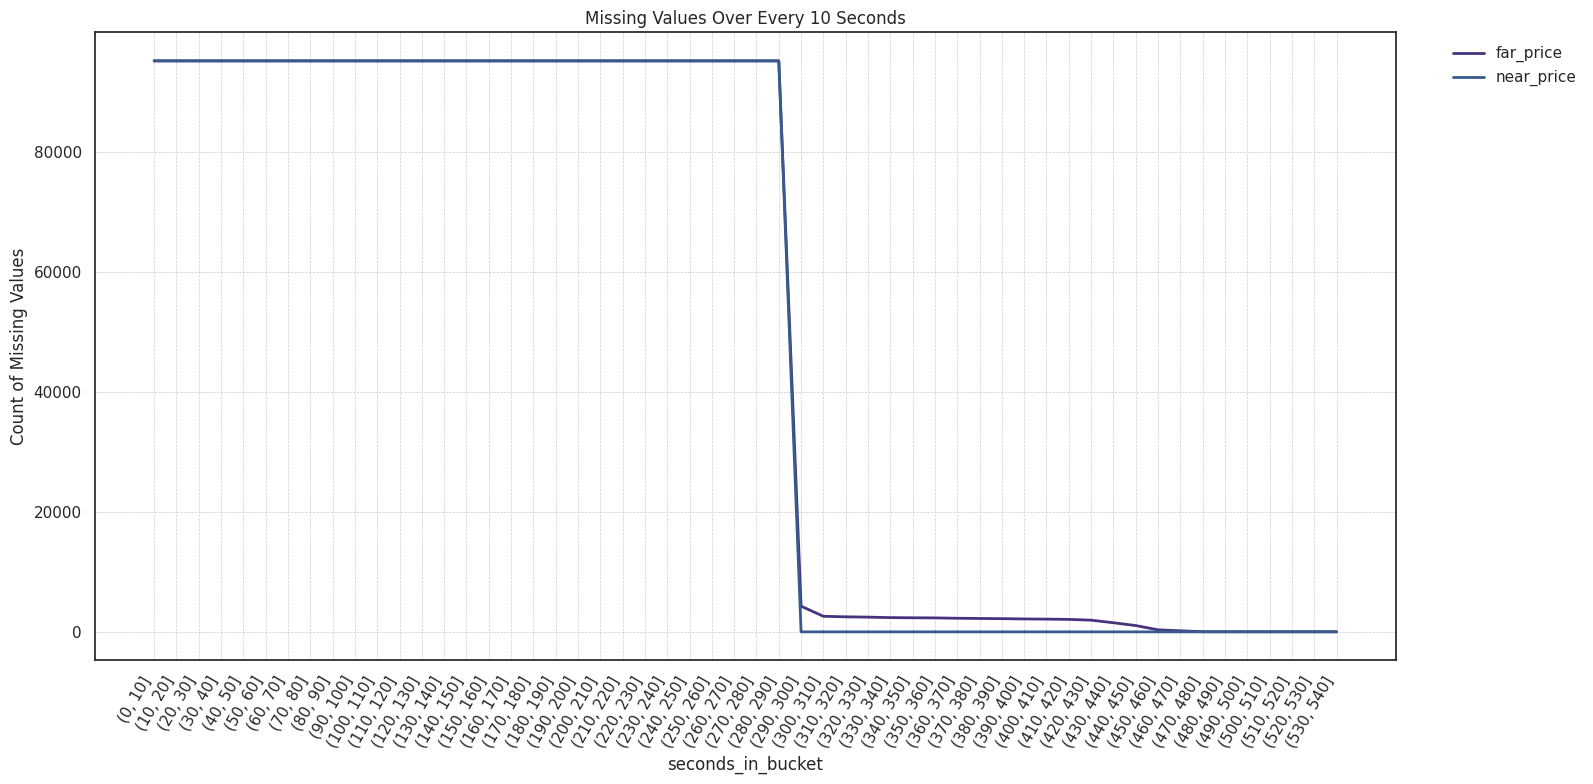

In [ ]:
import seaborn as sns
plt.figure(figsize=(16,8))

linewidth = 2.5

for column in ['far_price', 'near_price']:
    sns.lineplot(
        x=grpnan['seconds_in_bucket'].astype(str),
        y=grpnan[column],
        label=column,
        linewidth = 2
    )

plt.xticks(rotation=60, ha='right')

plt.title('Missing Values Over Every 10 Seconds')
plt.ylabel('Count of Missing Values')

plt.legend(
    loc='upper right',
    bbox_to_anchor=(1.15, 1.0),
    frameon=False
)

plt.grid(visible=True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [ ]:
train_vol.loc[df_train['target'].isna()]['stock_id'].unique()


array([132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 151, 152, 154, 155, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 191, 192, 193, 194, 195, 196, 197, 198,
       199,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45, 107])

In [ ]:
grpnan[['seconds_in_bucket','imbalance_size','reference_price', 'matched_size', 'bid_price', 'ask_price', 'wap']]

,seconds_in_bucket,imbalance_size,reference_price,matched_size,bid_price,ask_price,wap
0,"(0, 10]",2,2,2,2,2,2
1,"(10, 20]",2,2,2,2,2,2
2,"(20, 30]",2,2,2,2,2,2
3,"(30, 40]",2,2,2,2,2,2
4,"(40, 50]",2,2,2,2,2,2
5,"(50, 60]",2,2,2,2,2,2
6,"(60, 70]",2,2,2,2,2,2
7,"(70, 80]",2,2,2,2,2,2
8,"(80, 90]",2,2,2,2,2,2
9,"(90, 100]",2,2,2,2,2,2


In [ ]:
column_missing = ['imbalance_size', 'reference_price','matched_size','bid_price','ask_price','wap']

for colmn in column_missing:
    output = train_vol.loc[train_vol[colmn].isna()]['stock_id'].unique()
    print(f'{colmn} missing stock id: ', output)

imbalance_size missing stock id:  [131 101  19]
reference_price missing stock id:  [131 101  19]
matched_size missing stock id:  [131 101  19]
bid_price missing stock id:  [131 101  19]
ask_price missing stock id:  [131 101  19]
wap missing stock id:  [131 101  19]


In [ ]:
stk_na = [131, 101, 159, 19]
check_column = ['seconds_in_bucket','imbalance_size','reference_price', 'matched_size', 'bid_price', 'ask_price', 'wap']

for i in stk_na:
    dict_date = {}
    date_list = []
    dataframe = train_vol[train_vol['stock_id'] == i]

    print('**********************')
    print('stock_id', i)
    print('**********************')

    for j in check_column[1:]:
        val = list(dataframe.loc[dataframe[j].isna()]['date_id'].unique())
        print('date_id',val)
        date_list.append(val)

    dict_date[i] = date_list

**********************
stock_id 131
**********************
date_id [35]
date_id [35]
date_id [35]
date_id [35]
date_id [35]
date_id [35]
**********************
stock_id 101
**********************
date_id [328]
date_id [328]
date_id [328]
date_id [328]
date_id [328]
date_id [328]
**********************
stock_id 159
**********************
date_id []
date_id []
date_id []
date_id []
date_id []
date_id []
**********************
stock_id 19
**********************
date_id [438]
date_id [438]
date_id [438]
date_id [438]
date_id [438]
date_id [438]


In [ ]:
# clean data function
def clean_data(data):
    clean_data = data.copy()
    return clean_data[~clean_data['target'].isnull()].reset_index(drop= True)

In [ ]:
train_clean = clean_data(train_vol)

In [ ]:
# Replacing the near_price, far_price and reference_price
def replacebycond(data):
    cond = data['far_price'].isnull()

    data['far_price'] = np.where(cond, np.where(data['imbalance_buy_sell_flag'] == 1, data['ask_price'],
                                                     np.where(data['imbalance_buy_sell_flag'] == -1,
                                                              data['bid_price'], (data['bid_price']
                                                                                       + data['ask_price'])/2)),
                                      data['far_price'])

    data['near_price'] = np.where(cond, np.where(data['imbalance_buy_sell_flag'] == 1, data['ask_price'],
                                                     np.where(data['imbalance_buy_sell_flag'] == -1,
                                                              data['bid_price'], (data['bid_price']
                                                                                       + data['ask_price'])/2)),
                                      data['near_price'])

    data['reference_price'] = np.where(cond, np.where((data['near_price'] > data['bid_price']) &
                                                           (data['near_price'] < data['ask_price']),
                                                           data['near_price'],
                                                           np.where(data['near_price'] > data['ask_price'],
                                                                    data['ask_price'], data['bid_price'])),
                                           data['reference_price'])

    return data

In [ ]:
# function that is conditional
def cond_2(data):
    keep_copy = data.copy()

    # removing relevant missing values
    relavant_mval = keep_copy[~keep_copy['wap'].isnull()].reset_index(drop = True)

    ## Replace by conditions
    cond_2 = replacebycond(relavant_mval)

    return cond_2

In [ ]:
train_conditional = cond_2(train_vol)

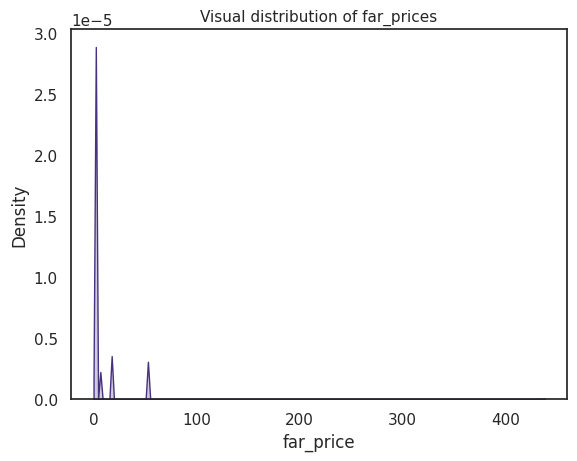

In [ ]:
# far_price histogram is plotted for better undersatnding of the outlier we suspected in the earlier display
sns.kdeplot(train_vol.far_price, fill= True)
plt.title('Visual distribution of far_prices', size = 11)
plt.show()

Mean value of far_price is: 1.0017128691026516


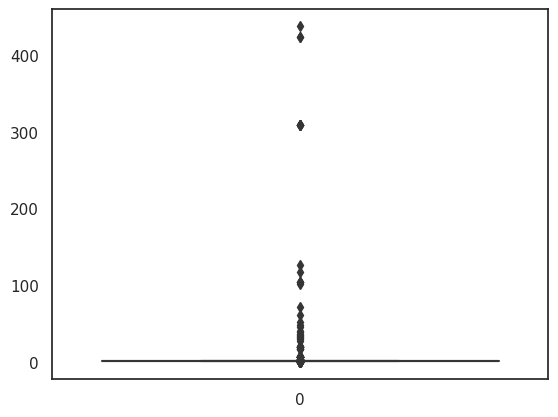

In [ ]:
# trying another display apart from histogram. The below given visual is boxplot
sns.boxplot(train_vol['far_price'])
print(f'Mean value of far_price is: {train_vol["far_price"].mean()}')
plt.show()

In [ ]:
# define the dataset that we are going to use for the testing
test_fea = test_set.dropna(subset=['wap']).reset_index(drop=True)

In [ ]:
# define the dataset that we are going to use for the training
train_fea = train_vol.dropna(subset=['wap']).reset_index(drop=True)

# Feature Engineering

#### def reduce_memory


This function reduce_memory(df) aims to reduce the memory usage of a pandas DataFrame by downcasting integer and float columns to smaller numeric types.
Memory-efficient implementations can scale better, allowing you to tackle larger problems or datasets without hitting memory constraints.

•	CatBoost: CatBoost is an algorithm that inherently handles categorical features efficiently, but reducing memory usage can still improve its performance by allowing it to allocate more memory to other tasks like feature selection or model optimization.

•	XGBoost (Extreme Gradient Boosting): XGBoost is known for its efficiency, but reducing memory usage can further enhance its scalability and speed by reducing memory overhead during model training.

•	LightGBM (Light Gradient Boosting Machine): LightGBM is designed to be memory-efficient and performant, but optimizing memory usage can still provide benefits, particularly when dealing with large-scale datasets or resource-constrained environments.


In [ ]:
def reduce_memory(df):
    int_columns = df.select_dtypes(include=['int']).columns
    float_columns = df.select_dtypes(include=['float']).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

    return df

#### def ma_features

1. Input Parameters:
* df: The pandas DataFrame containing the data.
* window_sizes: A list of window sizes for the moving averages.
* feature: The name of the column in the DataFrame for which moving averages are calculated.

2. Variables:
* window: This variable represents the default window size for the moving average calculation. In this case, it's set to 6.

3. Rolling Mean Calculation:
* rolled_cols = df.groupby(['stock_id', 'date_id'])[feature].rolling(window=window, min_periods=1).mean(): This line calculates the rolling mean of the specified feature column within each group defined by 'stock_id' and 'date_id'. It uses the .rolling() function provided by pandas to compute the rolling mean over a specified window size (window). The min_periods=1 argument ensures that even if there are fewer than window periods available for a group, a mean value is still computed using the available data.

4. Resetting Index:
* rolled_cols = rolled_cols.reset_index(level=[0, 1], drop=True): After calculating the rolling means, this line resets the index of the resulting DataFrame, dropping the 'stock_id' and 'date_id' level from the index, so that the resulting DataFrame has the same index as the original df.

5. Feature Name Generation:
* feature_name_std = f'{feature}_ma{window}': This line generates the name for the new feature column, which will contain the moving averages. It appends '_ma' followed by the window size to the original feature name.

6. Adding New Feature Column:
* df[feature_name_std] = rolled_cols: Finally, this line adds the new feature column containing the moving averages to the original DataFrame df.

7. Returning Updated DataFrame:
* return df: The function returns the DataFrame with the newly added moving average feature column.

In [ ]:
def mafeatures(df, window_sizes, feature):

    window = 6

    roll_cols = df.groupby(['stock_id', 'date_id'])[feature].rolling(window=window, min_periods=1).mean()
    roll_cols = roll_cols.reset_index(level=[0, 1], drop=True)
    feature_std = f'{feature}_ma{window}'
    df[feature_std] = roll_cols
    add_col.append(feature_std)

    return df

The below additional features (STD and RSI) complement the moving averages by providing information about volatility and momentum in the time series data. By incorporating these features, the model may gain a more comprehensive understanding of the underlying patterns and dynamics, potentially leading to improved predictive accuracy. A

In [ ]:
def add_features(df, feat_names):
    ewm_span = 12
    window = 12
    window_sizes = 6
    min_periods = 1
    method = 'bfill'

    for feature in feat_names:
        # Moving average
        df = mafeatures(df, window_sizes, feature)

        # Volatility
        feature_std = f'{feature}_std'
        df[feature_std] = df.groupby(['stock_id', 'date_id'])[feature].transform(lambda x: x.rolling(window=window, min_periods=min_periods).std().fillna(method=method))
        add_col.append(feature_std)


        # RSI
        feature_rsi = f'{feature}_rsi'
        df[feature_rsi] = df.groupby(['stock_id', 'date_id'])[feature].transform(lambda x: ta.momentum.RSIIndicator(x, window=window, fillna = True).rsi())
        add_col.append(feature_rsi)


    return df

In [ ]:
import ta
# Create new features list
num_woe = [fea for fea in numerical if fea not in ['far_price', 'near_price']]

add_col = []
train_fea = train_vol.copy()
train_fea = reduce_memory(train_fea)
train_fea = add_features(train_fea, num_woe)
features = numerical + categorical + ['seconds_in_bucket', 'date_id'] + add_col

In [ ]:
import pandas as pd

# `features` is a list of feature names
features_df = pd.DataFrame(features, columns=['Feature'])
features_df.to_csv('train_fea.csv', index=False)

In [ ]:
# Create new features list for the testing set
num_features_woe_test = [fea for fea in numerical_test if fea not in ['far_price', 'near_price']]

add_col = []
test_fea = test_set.copy()
test_fea = reduce_memory(test_fea)
test_fea = add_features(test_fea, num_features_woe_test)
features_test = numerical_test + categorical_test + ['seconds_in_bucket', 'date_id'] + add_col

In [ ]:
# features` is a list of feature names
features_test = pd.DataFrame(features, columns=['Feature'])
features_test.to_csv('test_fea.csv', index=False)


After saving the above feature engineering changes we have new transformed data loaded as below.

## Upload the train_stkmovement.csv as given in the file before running the below code

In [ ]:
import pandas as pd
path = "/kaggle/input/datareqdstkpred/archive/train_stkmovement.csv"
# path = "kaggle datasets download -d merlineclement/stock-movement"
stkmovement_train = pd.read_csv(path)


In [ ]:
stkmovement_train.head()


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,imbalance_size_ma6,imbalance_size_std,imbalance_size_rsi,reference_price_ma6,reference_price_std,reference_price_rsi,matched_size_ma6,matched_size_std,matched_size_rsi,bid_price_ma6,bid_price_std,bid_price_rsi,bid_size_ma6,bid_size_std,bid_size_rsi,ask_price_ma6,ask_price_std,ask_price_rsi,ask_size_ma6,ask_size_std,ask_size_rsi,wap_ma6,wap_std,wap_rsi
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,3180602.69,1.329948e+06,100.0,0.999812,0.000151,100.0,13380276.64,1.329948e+06,100.0,0.999812,0.000000,100.0,60651.50,32990.066876,100.0,1.000026,0.000000,100.0,8493.03,10625.078418,100.0,1.0,0.000076,100.0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,166603.91,4.813347e+02,100.0,0.999896,0.000042,100.0,1642214.25,4.813347e+02,100.0,0.999896,0.000000,100.0,3233.04,360.963870,100.0,1.000660,0.000000,100.0,20605.09,9271.817460,100.0,1.0,0.000019,100.0
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,302879.87,8.351897e+04,100.0,0.999561,0.000000,100.0,1819368.03,8.351896e+04,100.0,0.999403,0.000000,100.0,37956.00,0.000000,100.0,1.000298,0.000000,100.0,18995.00,13162.863442,100.0,1.0,0.000205,100.0
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,11917682.27,7.379711e+05,100.0,1.000171,0.000213,100.0,18389745.62,7.379711e+05,100.0,0.999999,0.000091,100.0,2324.90,1315.204471,100.0,1.000214,0.000122,100.0,479032.40,330178.137464,100.0,1.0,0.000088,100.0
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,447549.96,2.107724e+04,100.0,0.999532,0.000440,100.0,17860614.95,2.107725e+04,100.0,0.999394,0.000537,100.0,16485.54,8707.129056,100.0,1.000016,0.000293,100.0,434.10,9929.122711,100.0,1.0,0.000239,100.0


In [ ]:
stkmovement_train.tail()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,imbalance_size_ma6,imbalance_size_std,imbalance_size_rsi,reference_price_ma6,reference_price_std,reference_price_rsi,matched_size_ma6,matched_size_std,matched_size_rsi,bid_price_ma6,bid_price_std,bid_price_rsi,bid_size_ma6,bid_size_std,bid_size_rsi,ask_price_ma6,ask_price_std,ask_price_rsi,ask_size_ma6,ask_size_std,ask_size_rsi,wap_ma6,wap_std,wap_rsi
5237887,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195,2.300572e+06,1.008552e+06,56.105943,1.000278,0.000135,53.776514,2.824899e+07,467563.327809,97.880042,1.000278,0.000142,53.223919,33371.105000,17370.962279,51.121632,1.000395,0.000142,52.683937,134001.741667,75085.068200,72.337802,1.000305,0.000143,51.917869
5237888,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196,2.926395e+05,1.449399e+05,34.752138,1.000557,0.000256,60.593942,9.244570e+06,173691.398954,79.654525,1.000557,0.000256,60.818532,139431.433333,50454.145103,68.490824,1.000814,0.000256,60.727638,80761.336667,26802.835252,56.224215,1.000710,0.000268,60.371647
5237889,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197,8.472988e+05,3.872707e+05,30.268662,0.996055,0.000143,32.279920,1.265710e+07,129849.540483,99.938982,0.996023,0.000157,35.318765,37059.383333,24800.143046,47.868406,0.996257,0.000223,28.274170,139729.161667,64253.594753,58.379983,0.996070,0.000152,34.179097
5237890,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198,3.336329e+05,3.895993e+05,64.785788,0.999210,0.000094,39.099935,9.444392e+07,659149.635073,99.310816,0.999130,0.000145,28.558361,399274.503333,167780.915352,41.063351,0.999371,0.000145,28.540891,630464.336667,181308.489330,60.913438,0.999218,0.000166,28.787098
5237891,199,480,540,1884285.71,-1,1.002129,24073677.32,1.000859,1.001494,1.002129,250081.44,1.002447,300167.56,1.002274,-6.530285,26454,480_540_199,1.904641e+06,9.813535e+05,52.698990,1.002182,0.000370,57.293043,2.396416e+07,110752.770233,99.854053,1.002182,0.000370,58.643855,324552.626667,144617.139422,50.621764,1.002500,0.000370,58.650793,316379.846667,116499.471463,59.080316,1.002337,0.000362,57.253392


In [ ]:
features = numerical + categorical + ['seconds_in_bucket']

# X_raw = train_fea[features].values
# y_raw = train_fea['target'].values

X_cond = stkmovement_train[features].values
y_cond = stkmovement_train['target'].values

In [ ]:
num_features = len(features)
print("Number of features:", num_features)


Number of features: 13


In [ ]:
features_test = numerical_test + categorical_test + ['seconds_in_bucket']

# X_raw = train_fea[features].values
# # y_raw = train_fea['target'].values

# X_cond = stkmovement_train[features_test].values
# y_cond = stkmovement_train['target'].values

In [ ]:
num_feat = len(features_test)
print("Number of features:", num_feat)


Number of features: 13


Get the features for the test set


In [ ]:
# Get the features for the test set

x_test = test_set[features_test].values
# Get the target variable for the test set
y_test = test_set['target'].values

### Prepare for cross validation

In [ ]:
from sklearn.model_selection import train_test_split
# split the dataset into train and test set
X_train, x_test, Y_train, y_test = train_test_split(X_cond, y_cond, test_size=0.2, random_state=42)

# Package the splits into tests
tests = [(X_train, Y_train), (x_test, y_test)]

In [ ]:
kfcv = KFold(n_splits = 4)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def k_fold(model, X, y, kfcv):
    mae_fold = []
    rmse_fold = []

    for train_ind, val_ind in kfcv.split(X):
        x_train, x_val = X[train_ind], X[val_ind]
        y_train, y_val = y[train_ind], y[val_ind]
        evals = [(x_val, y_val)]

        model.fit(x_train, y_train,
                eval_set=evals,
                verbose=False)

        pred = model.predict(x_val)
        mae = mean_absolute_error(y_val, pred)
        mae_fold.append(mae)

        rmse = np.sqrt(mean_squared_error(y_val, pred))
        rmse_fold.append(rmse)

    return np.mean(mae_fold), np.mean(rmse_fold)


In [ ]:
from sklearn.model_selection import train_test_split

# Train_test split (80:20)
X = X_cond.copy()
y = y_cond.copy()

# Split data into 80% training and 20% validation, with random shuffling
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Package the splits into evals
evals = [(x_train, y_train), (x_val, y_val)]

In [ ]:
model_dict = {'xgb': xgb.XGBRegressor(n_estimators = 5000,
                                      tree_method = 'hist',
                                      device = "cuda",
                                      objective = 'reg:absoluteerror'),
              'lgb': lgb.LGBMRegressor(n_estimators = 5000,
                                        device = "gpu",
                                       objective = 'regression_l1')
             }

In [ ]:
!pip install lightgbm --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.2.0
    Uninstalling lightgbm-4.2.0:
      Successfully uninstalled lightgbm-4.2.0


In [ ]:

# Load configuration
params = {
    'config': 'lightgbm_gpu.conf'
}


# ROC, F1-score
Not applicable to the given y-label as the data in the column 'target' is not binary but sequencial or continous values.

Continous value cannot support ROC calculation and AUC calculation.

# XGBOOST

[0]	validation_0-mae:6.37520	validation_0-rmse:9.41755	validation_1-mae:6.37143	validation_1-rmse:9.39945
[1]	validation_0-mae:6.35818	validation_0-rmse:9.39378	validation_1-mae:6.35454	validation_1-rmse:9.37651
[2]	validation_0-mae:6.34961	validation_0-rmse:9.37952	validation_1-mae:6.34625	validation_1-rmse:9.36438
[3]	validation_0-mae:6.34436	validation_0-rmse:9.36956	validation_1-mae:6.34127	validation_1-rmse:9.35668
[4]	validation_0-mae:6.34089	validation_0-rmse:9.36146	validation_1-mae:6.33816	validation_1-rmse:9.35090
[5]	validation_0-mae:6.33737	validation_0-rmse:9.35336	validation_1-mae:6.33500	validation_1-rmse:9.34483
[6]	validation_0-mae:6.33549	validation_0-rmse:9.34721	validation_1-mae:6.33337	validation_1-rmse:9.34024
[7]	validation_0-mae:6.33072	validation_0-rmse:9.33799	validation_1-mae:6.32907	validation_1-rmse:9.33286
[8]	validation_0-mae:6.32697	validation_0-rmse:9.33114	validation_1-mae:6.32566	validation_1-rmse:9.32738
[9]	validation_0-mae:6.32483	validation_0-rmse

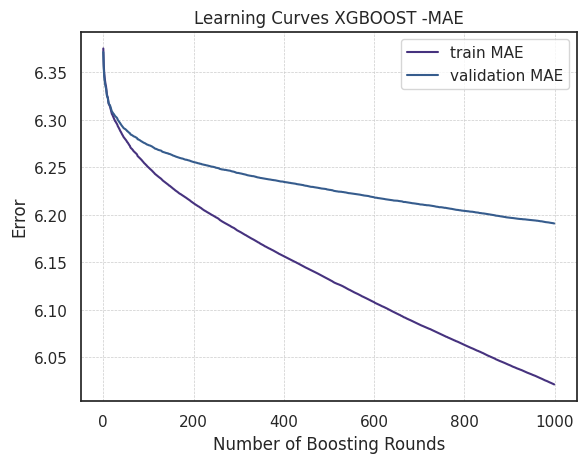

Training MAE: 6.021612030633128, Training RMSE: 8.582786808074454
Validation MAE: 6.190996875141448, Validation RMSE: 8.99666937670383
Training time: 641.296707868576 seconds


In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

# Specify XGBoost parameters with CPU training
xgb_params = {
    "objective": "reg:squarederror",  # For regression tasks
    "eval_metric": ["mae", "rmse"],    # Included both MAE and RMSE as evaluation metrics
    "n_estimators": 1000,              # Number of boosting rounds
    "early_stopping_rounds": 50        # Stop training if no improvement for 50 rounds
}

# Create the XGBoost model with the specified parameters
model_xgb = xgb.XGBRegressor(**xgb_params)

# Fit the model using the specified evaluation set
evals = [(x_train, y_train), (x_val, y_val)]

# Start the timer
start_time = time.time()

# Fit the model
model_xgb.fit(x_train, y_train, eval_set=evals, verbose=True)

# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Get the predictions
y_pred_train = model_xgb.predict(x_train)
y_pred_val = model_xgb.predict(x_val)


# Calculate MAE and RMSE
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)

# Plot learning curves
results = model_xgb.evals_result_

plt.plot(results['validation_0']['mae'], label='train MAE')
plt.plot(results['validation_1']['mae'], label='validation MAE')

plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Error')
plt.title('Learning Curves XGBOOST -MAE')
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()

# Display MAE and RMSE scores
print(f"Training MAE: {mae_train}, Training RMSE: {rmse_train}")
print(f"Validation MAE: {mae_val}, Validation RMSE: {rmse_val}")

# Display training time
print(f"Training time: {training_time} seconds")


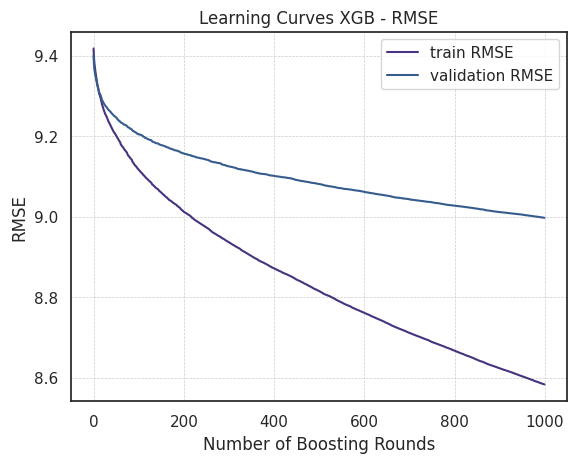

Training MAE: 6.021612030633128, Training RMSE: 8.582786808074454
Validation MAE: 6.190996875141448, Validation RMSE: 8.99666937670383


In [ ]:
# Plot learning curves
results = model_xgb.evals_result_

plt.plot(results['validation_0']['rmse'], label='train RMSE')
plt.plot(results['validation_1']['rmse'], label='validation RMSE')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Learning Curves XGB - RMSE')
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()

# Display MAE and RMSE scores
print(f"Training MAE: {mae_train}, Training RMSE: {rmse_train}")
print(f"Validation MAE: {mae_val}, Validation RMSE: {rmse_val}")



[-1.369624   4.195244   3.4421594 ...  2.287281   1.8201753 -3.0956023]
Test MAE: 5.684472540599678, Test RMSE: 8.497616793860312


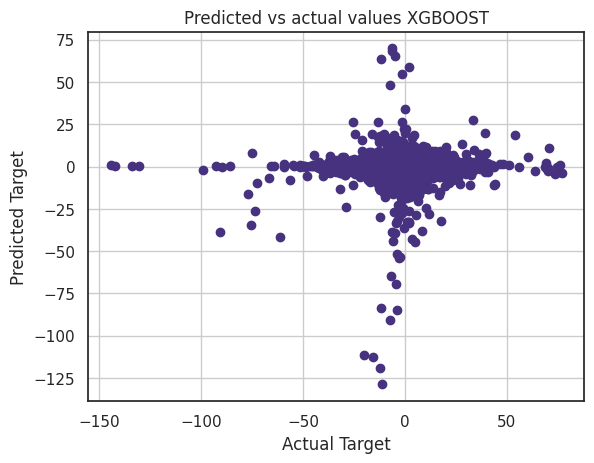

In [ ]:
# Drop rows with NaN values from the test set
test_set_clean = test_set.dropna(subset=['target'])

# Get the features for the test set
x_test = test_set_clean[features_test].values

# Get the target variable for the test set
y_test = test_set_clean['target'].values

# Make predictions on the test set
y_pred_test = model_xgb.predict(x_test)
print(y_pred_test)

# Calculate evaluation metrics (MAE and RMSE) on the test set
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"Test MAE: {mae_test}, Test RMSE: {rmse_test}")


# Plot predicted vs actual values scatter plot
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Predicted vs actual values XGBOOST')
plt.grid(True)
plt.show()


In [ ]:
print(y_pred_test)

[-1.369624   4.195244   3.4421594 ...  2.287281   1.8201753 -3.0956023]


In [ ]:
# Print shapes of test_set and predictions
print("Shape of test_set:", test_set.shape)
print("Shape of predictions:", y_pred_test.shape)

# Check for NaN values in predictions
print("Number of NaN values in predictions:", np.isnan(y_pred_test).sum())


Shape of test_set: (33000, 17)
Shape of predictions: (32892,)
Number of NaN values in predictions: 0


In [ ]:
# Check for NaN values in the target column of test_set
print("Number of NaN values in test_set['target']:", test_set['target'].isnull().sum())


Number of NaN values in test_set['target']: 108


1. Mean Squared Error (MSE):

MSE measures the average squared difference between the predicted values and the actual values.
In your case, the MSE is 72.209, which means, on average, the squared difference between the predicted and actual values is approximately 72.209.
Lower values of MSE indicate better model performance, as they imply that the model's predictions are closer to the actual values.

2. Correlation Coefficient:

The correlation coefficient measures the strength and direction of the linear relationship between two variables.
In your case, the correlation coefficient is 0.017, which indicates a very weak positive linear relationship between the predicted and actual values.
A correlation coefficient close to 1 or -1 indicates a strong positive or negative linear relationship, respectively, while a value close to 0 indicates little to no linear relationship.

In [ ]:
# joblib.dump(model_xgb, '/kaggle/working/xgboost_model_1.pkl')


['/kaggle/working/xgboost_model_1.pkl']

# LIGHT GBM

In [ ]:

import time

# LightGBM parameters with GPU training
lgb_params = {
    "objective": "regression",
    "metric": ["mae", "rmse"],  # Include RMSE as an evaluation metric
    "device": "cpu",  # Specify the device here
    "n_estimators": 1000  # Set the number of boosting rounds to 1000
}

# Create the LightGBM model with the specified parameters
model_lgbm = lgb.LGBMRegressor(**lgb_params, verbose=-1)

# Start the timer
start_time = time.time()

# Fit the model
model_lgbm.fit(x_train, y_train, eval_set=evals)

# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Get the predictions
y_pred_train = model_lgbm.predict(x_train)
y_pred_val = model_lgbm.predict(x_val)

# Calculate MAE and RMSE
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)

# Display MAE and RMSE scores
print(f"Training MAE: {mae_train}, Training RMSE: {rmse_train}")
print(f"Validation MAE: {mae_val}, Validation RMSE: {rmse_val}")

Training MAE: 6.200828739157212, Training RMSE: 8.98722949251904
Validation MAE: 6.245430233631201, Validation RMSE: 9.121511925389148


MAE learning curve for LGBM

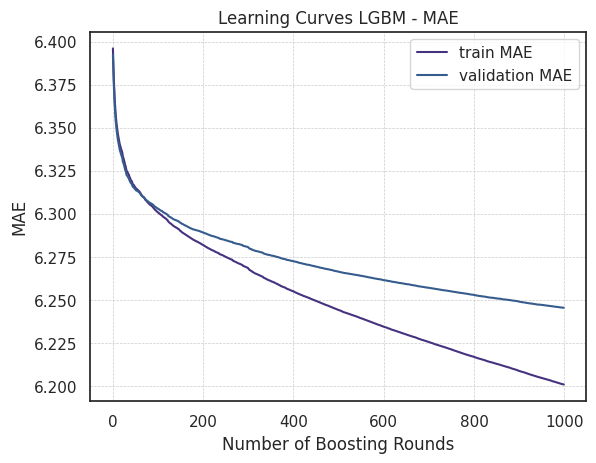

Training MAE: 6.200828739157212, Training RMSE: 8.98722949251904
Validation MAE: 6.245430233631201, Validation RMSE: 9.121511925389148
Training time: 219.7832510471344 seconds


In [ ]:
# Plot learning curves
results = model_lgbm.evals_result_

plt.plot(results['training']['l1'], label='train MAE')
plt.plot(results['valid_1']['l1'], label='validation MAE')
# plt.plot(results['training']['l2'], label='train RMSE')
# plt.plot(results['valid_1']['l2'], label='validation RMSE')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('MAE')
plt.title('Learning Curves LGBM - MAE')
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()

# Display MAE and RMSE scores
print(f"Training MAE: {mae_train}, Training RMSE: {rmse_train}")
print(f"Validation MAE: {mae_val}, Validation RMSE: {rmse_val}")

# Display training time
print(f"Training time: {training_time} seconds")

RMSE curve for LGBM

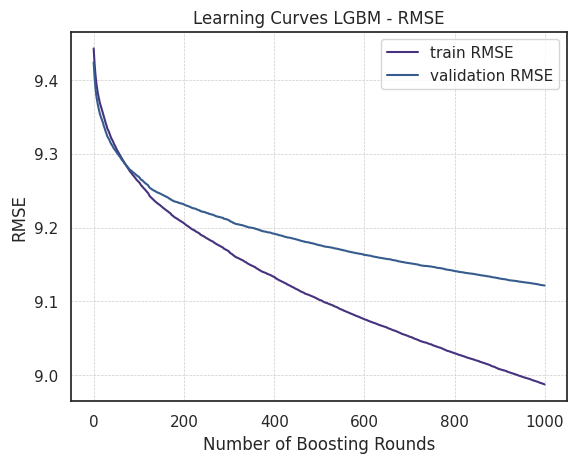

Training MAE: 6.200828739157212, Training RMSE: 8.98722949251904
Validation MAE: 6.245430233631201, Validation RMSE: 9.121511925389148
Training time: 219.7832510471344 seconds


In [ ]:
# Plot learning curves
results = model_lgbm.evals_result_

# plt.plot(results['training']['l1'], label='train MAE')
# plt.plot(results['valid_1']['l1'], label='validation MAE')
plt.plot(results['training']['rmse'], label='train RMSE')
plt.plot(results['valid_1']['rmse'], label='validation RMSE')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Learning Curves LGBM - RMSE')
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()

# Display MAE and RMSE scores
print(f"Training MAE: {mae_train}, Training RMSE: {rmse_train}")
print(f"Validation MAE: {mae_val}, Validation RMSE: {rmse_val}")

# Display training time
print(f"Training time: {training_time} seconds")

In [ ]:
# joblib.dump(model_lgbm, '/kaggle/working/LGBM_model_1.pkl')


['/kaggle/working/LGBM_model_1.pkl']

[-1.71361561  1.53805316  3.60102535 ...  1.20255164  2.08404961
 -2.11541656]
Test MAE: 5.572017957921678, Test RMSE: 8.249570161658944
Test Time: 0.8988947868347168


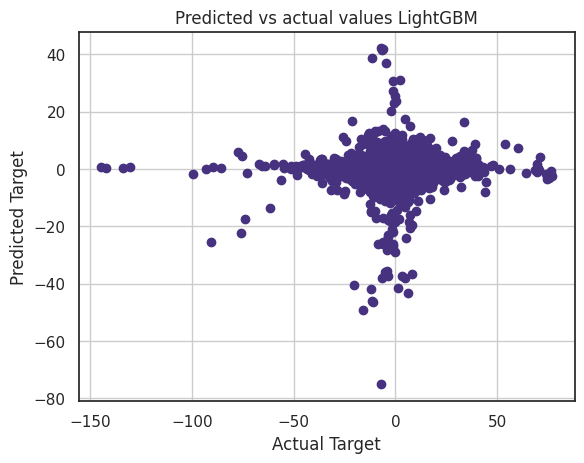

In [ ]:
# Drop rows with NaN values from the test set
test_set_clean = test_set.dropna(subset=['target'])

# Get the features for the test set
x_test = test_set_clean[features_test].values

# Get the target variable for the test set
y_test = test_set_clean['target'].values
test_tm = time.time()
# Make predictions on the test set
y_pred_test = model_lgbm.predict(x_test)
print(y_pred_test)

# Calculate evaluation metrics (MAE and RMSE) on the test set
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
stop = time.time()
test_lgbm = stop - test_tm

print(f"Test MAE: {mae_test}, Test RMSE: {rmse_test}")

print(f'Test Time: {test_lgbm}')
# Plot predicted vs actual values scatter plot
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Predicted vs actual values LightGBM')
plt.grid(True)
plt.show()


# CATBOOST

0:	learn: 6.4053289	test: 6.4016566	best: 6.4016566 (0)	total: 773ms	remaining: 12m 52s
200:	learn: 6.3267107	test: 6.3232046	best: 6.3232046 (200)	total: 1m 51s	remaining: 7m 24s
400:	learn: 6.3112384	test: 6.3086404	best: 6.3086404 (400)	total: 3m 40s	remaining: 5m 29s
600:	learn: 6.3009669	test: 6.2994118	best: 6.2994118 (600)	total: 5m 27s	remaining: 3m 37s
800:	learn: 6.2930840	test: 6.2927403	best: 6.2927403 (800)	total: 7m 12s	remaining: 1m 47s
999:	learn: 6.2869271	test: 6.2877553	best: 6.2877553 (999)	total: 8m 59s	remaining: 0us

bestTest = 6.287755269
bestIteration = 999



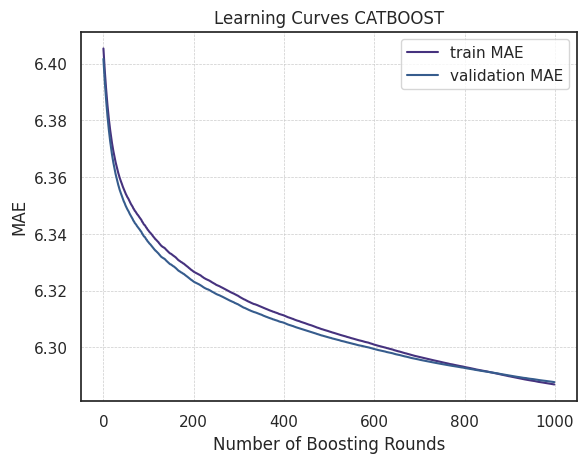

Training MAE: 6.286928140632725, Training RMSE: 9.29941437897222
Validation MAE: 6.287756268971717, Validation RMSE: 9.287805046730291
Training time: 577.6164910793304 seconds


In [ ]:
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

# Create the CatBoost model with the specified parameters
model_catboost = CatBoostRegressor(iterations=1000,  # Specify the number of boosting iterations
                                   loss_function='MAE',  # Use Mean Absolute Error as the loss function
                                   eval_metric='MAE',  # Use Mean Absolute Error as the evaluation metric
                                   verbose=200)  # Set verbosity to see training progress

# Start the timer
start_time = time.time()

# Fit the model
model_catboost.fit(x_train, y_train, eval_set=(x_val, y_val), use_best_model=True)

# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Get the predictions
y_pred_train = model_catboost.predict(x_train)
y_pred_val = model_catboost.predict(x_val)

# Calculate MAE and RMSE
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)

# Plot learning curves
plt.plot(model_catboost.get_evals_result()['learn']['MAE'], label='train MAE')
plt.plot(model_catboost.get_evals_result()['validation']['MAE'], label='validation MAE')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('MAE')
plt.title('Learning Curves CATBOOST')
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()

# Display MAE and RMSE scores
print(f"Training MAE: {mae_train}, Training RMSE: {rmse_train}")
print(f"Validation MAE: {mae_val}, Validation RMSE: {rmse_val}")

# Display training time
print(f"Training time: {training_time} seconds")


[-1.29681829  1.69071734  3.61814986 ...  0.87425424  1.7292205
 -2.3383585 ]
Test MAE: 5.492345361973086, Test RMSE: 8.121419505410074
Training time: 0.027040958404541016 seconds


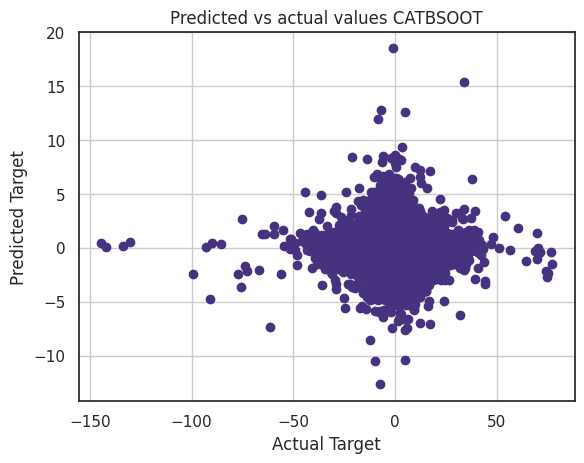

In [ ]:
# Drop rows with NaN values from the test set
test_set_clean = test_set.dropna(subset=['target'])

# Get the features for the test set
x_test = test_set_clean[features_test].values

# Get the target variable for the test set
y_test = test_set_clean['target'].values


# Start the timer
start_time = time.time()

# Make predictions on the test set
y_pred_test = model_catboost.predict(x_test)
print(y_pred_test)
# Save predicted values to a file
np.save('predicted_values_catboost.npy', y_pred_test)

# End the timer
end_time = time.time()

# Calculate evaluation metrics (MAE and RMSE) on the test set
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"Test MAE: {mae_test}, Test RMSE: {rmse_test}")


# Calculate the training time
test_time = end_time - start_time
# Display training time
print(f"Training time: {test_time} seconds")


# Plot predicted vs actual values scatter plot
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Predicted vs actual values CATBSOOT')
plt.grid(True)
plt.show()


In [ ]:
# # Convert predicted values to DataFrame
# df_catboost_predictions = pd.DataFrame({'predicted_values_catboost': y_pred_test})

# # Save DataFrame to CSV
# df_catboost_predictions.to_csv('catboost_predicted_values.csv', index=False)

In [ ]:
# joblib.dump(model_catboost, '/kaggle/working/catboost_model_1.pkl')


['/kaggle/working/catboost_model_1.pkl']

# Neural Network Model

# LSTM

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision


2024-05-16 13:43:07.581480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 13:43:07.581590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 13:43:07.767235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
train_lstm= "/kaggle/input/datareqdstkpred/optiver-trading-at-the-close/train.csv"
test_lstm = pd.read_csv("/kaggle/input/datareqdstkpred/test.csv/test.csv")

Mixed precision training is a technique used to accelerate training of deep neural networks by using a combination of 16-bit and 32-bit floating point numbers.

In [ ]:
mixedPrecisionEnable = True

The memory usage across the kernel is defined by the below function.
Ref:
    https://stackoverflow.com/questions/61366458/how-to-find-memory-usage-of-kaggle-notebook
    

This checkingMemory() function aims to check the RAM memory usage of the process where it's executed, particularly useful for monitoring memory consumption during the execution of deep learning models like LSTM (Long Short-Term Memory).

In [ ]:

def checkingMemory():

    pid_lstm = getpid();
    py_lstm = Process(pid_lstm);
    memory_tag = py_lstm.memory_info()[0] / 2. ** 30;
    return f"RAM memory GB usage = {memory_tag :.4}";

The reason for this additional step is to get fine-grained control over how mixed precision training is applied. By explicitly setting the policy,it can customize operations in the model which will use mixed precision and which will remain in full precision (e.g., 32-bit floating point).

In [ ]:
strat = tf.distribute.MirroredStrategy()
print('Number of GPU devices: {}'.format(strat.num_replicas_in_sync))

Number of GPU devices: 2


In [ ]:
if mixedPrecisionEnable == True:
    pol = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(pol)

Printing the specific data types that will be used for computations and model variables when mixed precision training is enabled.

In [ ]:
if mixedPrecisionEnable == True:
    print('Compute dtype: %s' % pol.compute_dtype)
    print('Variable dtype: %s' % pol.variable_dtype)

Compute dtype: float16
Variable dtype: float32


The below function will inspect on the data type policies of the layers in a TensorFlow model, particularly when mixed precision training is enabled.

In [ ]:
def PolicyOfModel(model):
    # Iterate over each layer in the model
    for layer in model.layers:
        # Printing the layer followed by its dtype policy
        print(f"{layer.name:20} {layer.dtype_policy}")

Global Configuration: The variables defined in all caps at the beginning of the script appear to be global configuration parameters for the model training process. They specify various hyperparameters such as the number of lag observations (LAGS), batch size (B_SIZE), epochs (EPOCHS), and others. By defining these parameters at the beginning of the script in a consistent manner, it's easy to modify them when necessary and to understand their significance in the context of the overall program.

In [ ]:
SEED = 42

N_LAGS =    20 #tried different lags #12#6#3 #30

B_SIZE =   32 #tried 64
BUFFER_VOL = 100000 # for shuff function
EPOCHS =   300 # tried #500 no improvement
PATIENCE =  10# tried 5 but found 10 better
DROPOUT = 0.5# tried both found 0.5 better than 0.4#0.8#0.5
LEARN_RATE = 1e-4

SPLIT_DAY = 390

N_STOCKS = 200  # define the maximum stock id
N_DATES = 481 # define the maximum stock dates
N_SECONDS = 55  # define the maximum seconds 0- 540 second for each day


RUN_TRAINING = True
RUN_SUB = True

The below code ensures that both Python's hash function and TensorFlow's random number generator produce consistent results across different runs of the program, which is essential for reproducibility when working with random processes in machine learning models

In [ ]:
# Sets the Python hash seed (PYTHONHASHSEED) environment variable to the value of the SEED constant.
os.environ['PYTHONHASHSEED'] = str(SEED)

# Sets sets the random seed for TensorFlow's random number generator to the value of the SEED constant.
tf.keras.utils.set_random_seed(SEED)

Selecting and choosing the relavant columns for processing and training.

In [ ]:
%%time
df_lstm = df_train[["stock_id", "date_id", "seconds_in_bucket", "target"]]
df_lstm.shape

CPU times: user 28.3 ms, sys: 29 ms, total: 57.3 ms
Wall time: 55.6 ms


(5237980, 4)

Function to reduce memory usage where and when possible,to keep it computationally efficient.

1. Calculate Initial Memory Usage:
start_mem :The memory usage is converted from bytes to megabytes.
2. Iterate Through Columns:
The function iterates through each column in the DataFrame.
3. Check Column Data Type and Range:
For each column, it checks its data type. If the data type is not an object (i.e., it's numeric), it proceeds to check the minimum and maximum values within that column.
4. Downcast Numeric Data Types:
Depending on the data range of the column, the function downcasts the data type to the smallest possible integer or floating-point type that can accommodate the range of values without loss of precision. This helps reduce memory usage without sacrificing data integrity.
5. Verbose Output (Optional):
If verbose is set to 1, the function prints information about the memory usage before and after optimization, as well as the percentage decrease in memory usage.
6. Return Optimized DataFrame:
This function returns the optimized DataFrame df_lstm.

In [ ]:
def red_mem_use(df_lstm, verbose=0):
    start_mem = df_lstm.memory_usage().sum() / 1024**2

    for col in df_lstm.columns:
        col_type = df_lstm[col].dtype

        if col_type != object:
            c_min = df_lstm[col].min()
            c_max = df_lstm[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df_lstm[col] = df_lstm[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df_lstm[col] = df_lstm[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df_lstm[col] = df_lstm[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df_lstm[col] = df_lstm[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df_lstm[col] = df_lstm[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df_lstm[col] = df_lstm[col].astype(np.float32)
                else:
                    df_lstm[col] = df_lstm[col].astype(np.float32)

    if verbose:
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df_lstm.memory_usage().sum() / 1024**2
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        print(f"Decreased by {decrease:.2f}%")

    return df_lstm

df_lstm = red_mem_use(df_lstm, verbose=1)

Memory usage of dataframe is 159.85 MB
Memory usage after optimization is: 49.95 MB
Decreased by 68.75%


In [ ]:
all_stock = range(N_STOCKS)
all_date = range(N_DATES)
all_seconds = [i * 10 for i in range(N_SECONDS)]

#Re-index full dataframe
multi_index = pd.MultiIndex.from_product([all_stock, all_date, all_seconds],
                                         names=['stock_id', 'date_id', 'seconds_in_bucket'])
df_full = df_train.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
df_full = df_full.fillna(0) # fill NA (miss value) into 0
df_full = df_full.reset_index()
assert(df_full.shape[0] == N_STOCKS * N_DATES * N_SECONDS)
df_full

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1.0,0.999812,13380276.64,0.000000,0.000000,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0.0,0_0_0
1,0,0,10,1299772.70,1.0,1.000026,15261106.63,0.000000,0.000000,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1.0,0_10_0
2,0,0,20,1299772.70,1.0,0.999919,15261106.63,0.000000,0.000000,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2.0,0_20_0
3,0,0,30,1299772.70,1.0,1.000133,15261106.63,0.000000,0.000000,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3.0,0_30_0
4,0,0,40,1218204.43,1.0,1.000455,15342674.90,0.000000,0.000000,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4.0,0_40_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5290995,199,480,500,2661783.46,-1.0,1.002764,23969215.23,1.000859,1.001494,1.002764,122246.18,1.003082,425296.17,1.002835,-7.209778,26450.0,480_500_199
5290996,199,480,510,2658917.61,-1.0,1.002764,23972081.09,1.000859,1.001494,1.002764,677012.04,1.003082,347268.87,1.002974,-9.750128,26451.0,480_510_199
5290997,199,480,520,1352558.88,-1.0,1.001812,23978379.68,1.000859,1.001494,1.001812,225361.65,1.002129,194630.52,1.001982,3.629923,26452.0,480_520_199
5290998,199,480,530,1352558.88,-1.0,1.001812,23978379.68,1.000859,1.001494,1.001812,285559.05,1.002129,214513.32,1.001993,4.760027,26453.0,480_530_199


In [ ]:
import gc
gc.collect()

23

In [ ]:
# Re-index full dataframe
multi_index = pd.MultiIndex.from_product([all_stock, all_date, all_seconds],
                                         names=['stock_id', 'date_id', 'seconds_in_bucket'])
df_ful = df_train.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
df_ful = df_ful.fillna(0)  # Fill NA (missing values) with 0
df_ful = df_ful.reset_index()

# Retain only desired columns
df_ful = df_ful[['stock_id', 'date_id', 'seconds_in_bucket', 'target']]

assert df_ful.shape[0] == N_STOCKS * N_DATES * N_SECONDS
df_ful

,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,-3.029704
1,0,0,10,0.389814
2,0,0,20,4.220009
3,0,0,30,5.450249
4,0,0,40,3.169775
...,...,...,...,...
5290995,199,480,500,-7.209778
5290996,199,480,510,-9.750128
5290997,199,480,520,3.629923
5290998,199,480,530,4.760027


In [ ]:
gc.collect()


0

In [ ]:
def visual(df_lstm, stock_id, date_id):
    df_train = df_lstm[(df_lstm.stock_id == stock_id) & (df_lstm.date_id == date_id)].copy()
    df_train.plot(x="seconds_in_bucket", y=["bid_price", "ask_price", "far_price", "near_price", "reference_price"])
    plt.title("bid_price, ask_price, far_price, near_price")
    plt.show()
    df_train.plot(x="seconds_in_bucket", y=["bid_price","ask_price", "wap", "reference_price"])
    plt.title("bid_price, ask_price, wap, refence_price")
    plt.show()
    df_train.plot(x="seconds_in_bucket", y=["target"])
    plt.title("target")
    plt.show()
    df_train.plot(x="seconds_in_bucket", y=["bid_size", "ask_size"])
    plt.title("bid_size, ask_size")
    plt.show()
    df_train.plot(x="seconds_in_bucket", y=['imbalance_size','matched_size'])
    plt.title("Imbalance_size, matched_size")
    plt.show()

In [ ]:
# pip install --upgrade pyarrow


Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip uninstall pyarrow -y
!pip install pyarrow
!pip uninstall <package_name>
!pip install <package_name>


Found existing installation: pyarrow 16.1.0
Uninstalling pyarrow-16.1.0:
  Successfully uninstalled pyarrow-16.1.0
  Using cached pyarrow-16.1.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.0 kB)
Using cached pyarrow-16.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (40.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires p

In [ ]:
# train_lstm = '/kaggle/input/requireddataset2/optiver-trading-at-the-close/train.csv'

In [ ]:
%%time
df_plot= pd.read_csv(train_lstm, engine="pyarrow")
# df_train = df_lstm[["stock_id", "date_id", "seconds_in_bucket", "target"]]
df_plot

CPU times: user 9.69 s, sys: 3.62 s, total: 13.3 s
Wall time: 5.08 s


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


comparision between features

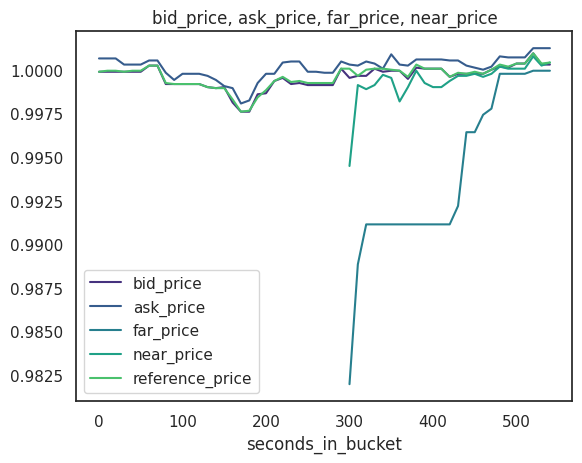

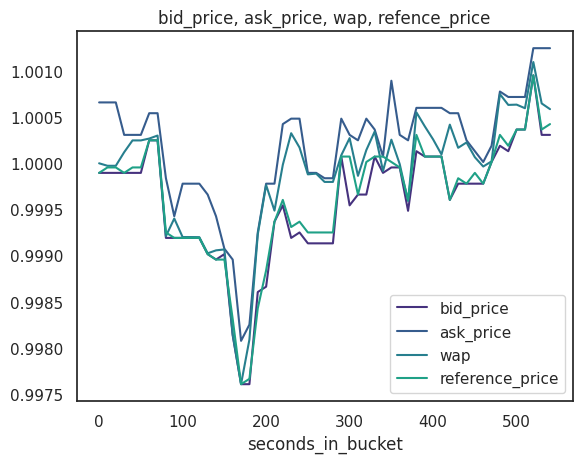

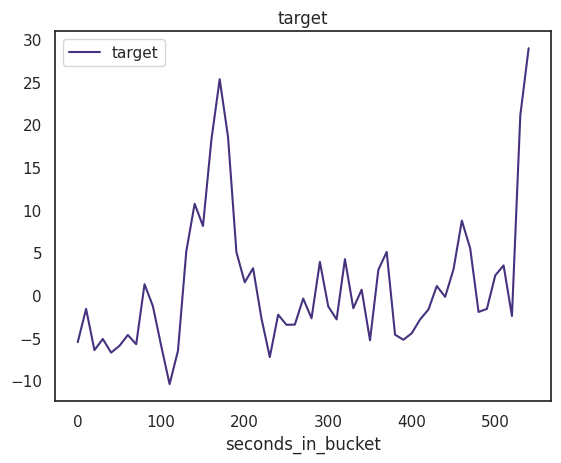

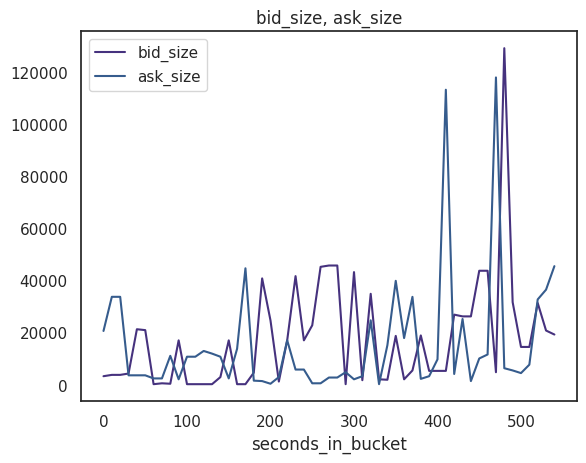

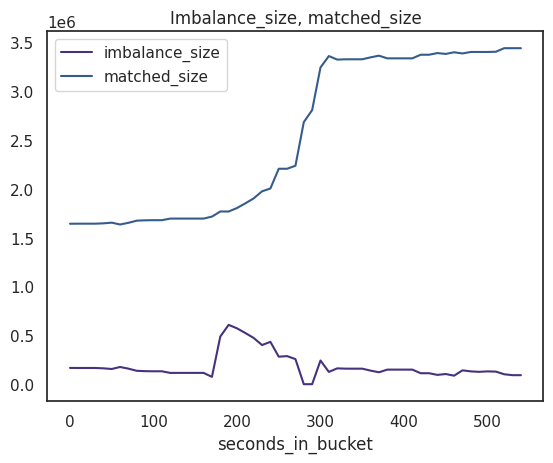

In [ ]:
visual(df_plot, 1, 0)


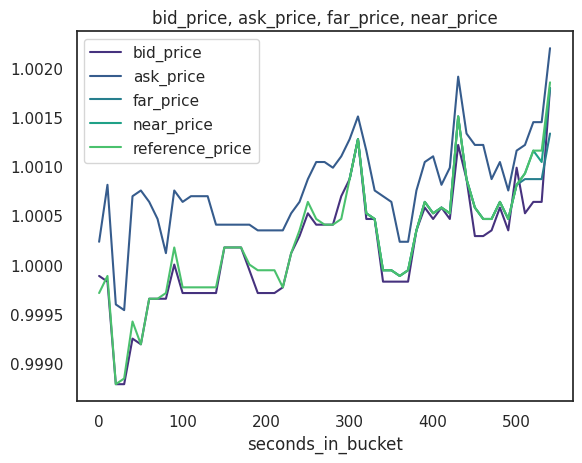

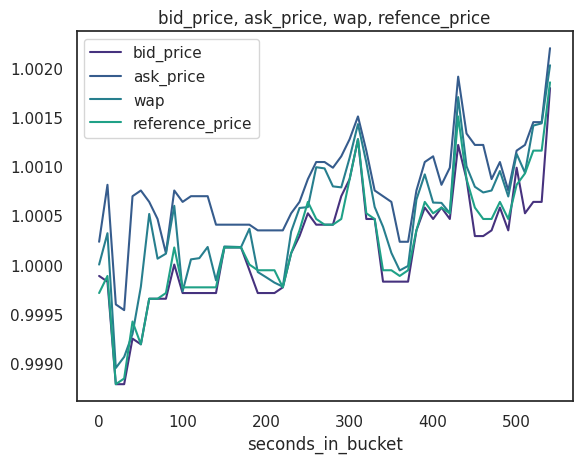

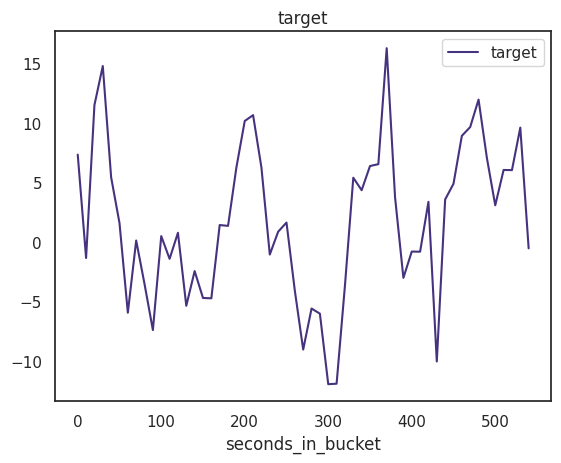

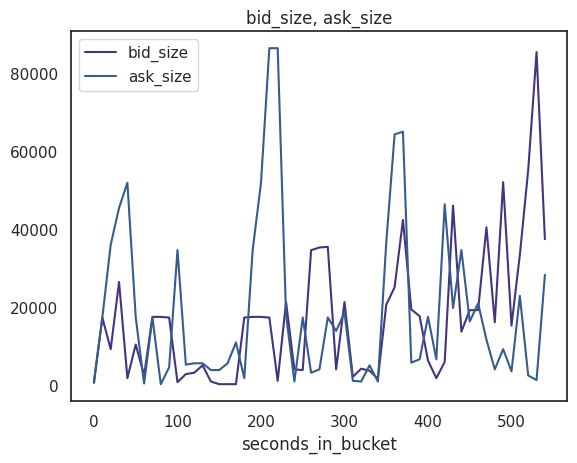

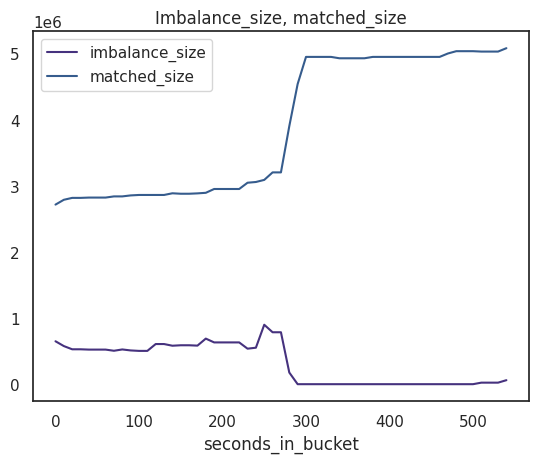

In [ ]:
visual(df_plot, 1, 1)


In [ ]:
import gc
gc.collect()


22915

Time series data refers to a sequence of data points collected or recorded at successive, equally spaced intervals over time. In TensorFlow, data is typically represented as tensors, which are multi-dimensional arrays. These tensors can hold numeric data, strings, or other types of data, and they are the fundamental building blocks for defining and manipulating data in TensorFlow.

The function "winbatch_dset" is designed to handle time series data. It performs several steps to prepare this data for training machine learning models. First, it converts the time series data into a format compatible with TensorFlow. Each window represents a segment of the time series, containing a sequence of data points that serve as input features for the model. Additionally, the next data point after each window is designated as the target label that the model aims to predict. Once the windows are defined, the function organizes them into batches, grouping multiple windows together. Finally, it prefetches these batches, optimizing the training process by loading data into memory in advance.

In [ ]:
def winbatch_dset(series, window_size=N_LAGS, batch_size=B_SIZE):

    data_s = tf.data.Dataset.from_tensor_slices(series)
    data_s = data_s.window(window_size + 1, shift=1, drop_remainder=True)
    data_s = data_s.flat_map(lambda w: w.batch(window_size + 1))
    data_s = data_s.map(lambda w: (w[:-1], w[-1]))
    return data_s.batch(batch_size).prefetch(1)

In [ ]:
def window_data2(data, shuffle=True):

    data = tf.data.Dataset.from_tensor_slices(data)
    data = data.window(N_LAGS + 1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda win: win.batch(N_LAGS + 1))
    data = data.map(lambda win: (win[:-1], win[-1]))
    if shuffle:
        data = data.shuffle(BUFFER_VOL)
    data = data.batch(B_SIZE).prefetch(1)
    return data


The function "build_features" takes a DataFrame containing time series data for multiple stocks, transforms it into a pivoted format suitable for time series analysis, and ensures comprehensive coverage by including all combinations of stock IDs, date IDs, and time intervals. It restructures the data into a pivot table format for further analysis and modeling.

In [ ]:
def pivot_features(df_lstm):
    stock_allids = range(N_STOCKS)
    date_allids = df_lstm["date_id"].unique() # find unqiue date id
    seconds_all = [i * 10 for i in range(N_SECONDS)]

    # Set multi-index (stock_id, date_id, seconds_in_bucket)
    multi_index = pd.MultiIndex.from_product([stock_allids, date_allids, seconds_all],
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df_full = df_lstm.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_full = df_full.fillna(0) # fill missing value with 0
    df_full = df_full.reset_index()

    #create pivot table
    df_pivot = df_full.pivot_table(
                values='target',       # set each row value is taget
                index=['date_id', 'seconds_in_bucket'], # ste date_id, seconds_in_bucket for index
                columns='stock_id')   # set stock_id  for column

    df_pivot = df_pivot.reset_index(drop=True) # remove new date_id, second_in_bucket index
    df_pivot.columns.name = None  # remove column name

    return df_pivot


test_Feat = pivot_features(df_full)
test_Feat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,-3.029704,-5.519986,-8.389950,-4.010200,-7.349849,6.779432,-2.499819,-1.959801,-5.970001,7.970333,5.350113,2.559423,8.399487,-10.750294,2.319813,1.720190,-8.170009,-3.589988,-11.439919,4.299879,-4.180074,-11.540055,8.959770,2.440214,4.489422,-2.560020,-0.349879,-0.060201,-1.689792,4.639626,4.409552,-1.389980,7.810593,4.420280,-7.759929,0.189543,3.540516,-0.429750,7.829666,-4.699826,-1.379847,4.960299,-10.669827,-3.340244,3.139973,-1.440048,17.149448,10.190010,-7.759929,9.260178,4.260540,6.710291,1.000166,-6.319881,-3.669858,-1.209974,10.479689,6.829500,-1.279712,-3.600121,-1.109838,3.130436,13.799667,2.030134,-22.730232,12.619495,-5.040169,-11.969805,4.080534,0.000000,9.670258,-17.859936,-5.580187,-2.560020,3.360510,-6.679893,-1.980066,0.269413,0.000000,0.000000,-9.639859,16.690493,6.530285,-1.080036,6.389618,-18.870235,30.519962,6.970167,-5.059838,-2.560020,1.510382,2.839565,-42.350292,10.509491,-10.070205,-8.310080,-5.000234,11.299849,-2.470016,13.680458,-5.229711,8.449554,0.000000,-1.760125,-5.210042,-1.279712,-8.040071,0.540018,-6.020069,-2.650022,-2.040267,-7.219911,-1.400113,-5.149841,-2.980232,-5.350113,3.399849,2.620220,-7.740259,4.169941,3.540516,-2.020001,9.529591,4.110336,-8.419752,9.089708,-8.580089,5.830526,0.669956,2.199411,-5.329847,5.910397,-17.660260,-2.020001,4.190207,0.000000,-2.840161,2.219677,-8.050203,2.789497,-1.209974,-9.080172,-4.119873,-6.880164,-3.039837,7.150173,0.840426,1.590252,11.310577,-1.990199,0.000000,-2.530217,-24.080276,0.000000,-4.929900,4.329681,0.000000,0.879765,-23.630260,-6.470084,-2.580285,-4.000068,-6.110072,-2.539754,4.899502,4.420280,4.919767,0.970364,0.979900,-11.439919,6.029606,-3.460050,-17.719864,-1.479983,19.199848,3.379583,10.509491,-35.930275,8.699894,-11.469722,0.369549,0.289679,14.599562,-4.379749,-4.739761,3.010035,-3.679991,6.380081,19.019842,5.480051,6.370544,11.940002,-11.529922,-6.489754,3.999472,-0.690222,-0.810027,-8.440018,-0.510216,0.000000
1,0.389814,-1.620054,-7.460117,-1.040101,-6.719828,7.710457,-4.280209,-8.010268,-0.780225,-0.640154,4.869700,5.400181,4.990101,-4.529953,-1.170039,1.280308,4.459619,-13.880134,1.620054,-2.880096,0.690222,-7.590056,-0.349879,7.879734,8.039475,0.779629,0.400543,9.820461,-8.559823,-6.729960,-0.839829,-14.879703,0.770092,7.189512,3.639460,-6.989837,4.450083,-1.410246,4.780292,-1.299977,2.969503,2.549887,-7.249713,-3.499985,8.339882,1.510382,1.330376,3.720522,-5.210042,-2.589822,6.580353,-3.560185,-7.659793,-5.069971,-1.519918,0.890493,2.290011,-0.230074,-3.749728,-3.650188,7.319450,-2.160072,32.110214,-0.590086,-4.199743,3.230572,-1.549721,-1.009703,2.299547,0.000000,-5.069971,-17.899872,-2.840161,-3.420114,-3.100038,-4.680157,-6.039739,2.299547,0.000000,0.000000,4.229546,31.059980,-2.629757,0.410080,-0.320077,-25.039911,58.059692,-8.580089,-1.729727,1.499653,2.369881,3.110170,-43.079853,-5.540252,-0.050068,-4.349947,-10.120273,9.479523,6.760359,8.009672,-3.020167,-0.349879,0.000000,-1.329780,-4.690289,0.410080,-5.139709,-13.489723,-8.820295,-0.309944,0.180006,-6.089807,3.850460,8.989573,9.980202,-5.639792,0.580549,0.669956,-9.660125,4.650354,3.969669,0.560284,16.169548,-2.099872,-19.760132,7.200241,-10.449886,4.210472,1.510382,-2.310276,-3.640056,12.069941,-6.489754,1.159906,3.010035,0.000000,1.440048,-10.359883,-5.409718,0.250339,3.169775,-14.479756,

In [ ]:

test_win = winbatch_dset(test_Feat)
test_win

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 200), dtype=tf.float64, name=None), TensorSpec(shape=(None, 200), dtype=tf.float64, name=None))>

In [ ]:
test_Feat.head(56)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,-3.029704,-5.519986,-8.389950,-4.010200,-7.349849,6.779432,-2.499819,-1.959801,-5.970001,7.970333,5.350113,2.559423,8.399487,-10.750294,2.319813,1.720190,-8.170009,-3.589988,-11.439919,4.299879,-4.180074,-11.540055,8.959770,2.440214,4.489422,-2.560020,-0.349879,-0.060201,-1.689792,4.639626,4.409552,-1.389980,7.810593,4.420280,-7.759929,0.189543,3.540516,-0.429750,7.829666,-4.699826,-1.379847,4.960299,-10.669827,-3.340244,3.139973,-1.440048,17.149448,10.190010,-7.759929,9.260178,4.260540,6.710291,1.000166,-6.319881,-3.669858,-1.209974,10.479689,6.829500,-1.279712,-3.600121,-1.109838,3.130436,13.799667,2.030134,-22.730232,12.619495,-5.040169,-11.969805,4.080534,0.0,9.670258,-17.859936,-5.580187,-2.560020,3.360510,-6.679893,-1.980066,0.269413,0.0,0.0,-9.639859,16.690493,6.530285,-1.080036,6.389618,-18.870235,30.519962,6.970167,-5.059838,-2.560020,1.510382,2.839565,-42.350292,10.509491,-10.070205,-8.310080,-5.000234,11.299849,-2.470016,13.680458,-5.229711,8.449554,0.0,-1.760125,-5.210042,-1.279712,-8.040071,0.540018,-6.020069,-2.650022,-2.040267,-7.219911,-1.400113,-5.149841,-2.980232,-5.350113,3.399849,2.620220,-7.740259,4.169941,3.540516,-2.020001,9.529591,4.110336,-8.419752,9.089708,-8.580089,5.830526,0.669956,2.199411,-5.329847,5.910397,-17.660260,-2.020001,4.190207,0.0,-2.840161,2.219677,-8.050203,2.789497,-1.209974,-9.080172,-4.119873,-6.880164,-3.039837,7.150173,0.840426,1.590252,11.310577,-1.990199,0.0,-2.530217,-24.080276,0.0,-4.929900,4.329681,0.0,0.879765,-23.630260,-6.470084,-2.580285,-4.000068,-6.110072,-2.539754,4.899502,4.420280,4.919767,0.970364,0.979900,-11.439919,6.029606,-3.460050,-17.719864,-1.479983,19.199848,3.379583,10.509491,-35.930275,8.699894,-11.469722,0.369549,0.289679,14.599562,-4.379749,-4.739761,3.010035,-3.679991,6.380081,19.019842,5.480051,6.370544,11.940002,-11.529922,-6.489754,3.999472,-0.690222,-0.810027,-8.440018,-0.510216,0.0
1,0.389814,-1.620054,-7.460117,-1.040101,-6.719828,7.710457,-4.280209,-8.010268,-0.780225,-0.640154,4.869700,5.400181,4.990101,-4.529953,-1.170039,1.280308,4.459619,-13.880134,1.620054,-2.880096,0.690222,-7.590056,-0.349879,7.879734,8.039475,0.779629,0.400543,9.820461,-8.559823,-6.729960,-0.839829,-14.879703,0.770092,7.189512,3.639460,-6.989837,4.450083,-1.410246,4.780292,-1.299977,2.969503,2.549887,-7.249713,-3.499985,8.339882,1.510382,1.330376,3.720522,-5.210042,-2.589822,6.580353,-3.560185,-7.659793,-5.069971,-1.519918,0.890493,2.290011,-0.230074,-3.749728,-3.650188,7.319450,-2.160072,32.110214,-0.590086,-4.199743,3.230572,-1.549721,-1.009703,2.299547,0.0,-5.069971,-17.899872,-2.840161,-3.420114,-3.100038,-4.680157,-6.039739,2.299547,0.0,0.0,4.229546,31.059980,-2.629757,0.410080,-0.320077,-25.039911,58.059692,-8.580089,-1.729727,1.499653,2.369881,3.110170,-43.079853,-5.540252,-0.050068,-4.349947,-10.120273,9.479523,6.760359,8.009672,-3.020167,-0.349879,0.0,-1.329780,-4.690289,0.410080,-5.139709,-13.489723,-8.820295,-0.309944,0.180006,-6.089807,3.850460,8.989573,9.980202,-5.639792,0.580549,0.669956,-9.660125,4.650354,3.969669,0.560284,16.169548,-2.099872,-19.760132,7.200241,-10.449886,4.210472,1.510382,-2.310276,-3.640056,12.069941,-6.489754,1.159906,3.010035,0.0,1.440048,-10.359883,-5.409718,0.250339,3.169775,-14.479756,-1.119971,-5.499721,-1.779795,-0.830293,1.759529,-5.589724,2.729893,0.

In [ ]:
gc.collect()

0

In [ ]:
# !pip install tf_keras


In [ ]:
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, LSTM, Dense
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf


warnings.filterwarnings("ignore")

Dropout randomly drops a proportion of neurons (units) in the neural network during training, effectively reducing the capacity of the network and preventing it from relying too much on specific neurons. This encourages the network to learn more robust and generalizable features.

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

Train the model

In [ ]:
# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# import random as python_random

from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers

In [ ]:
SEED = 42

LAGS = 55

B_SIZE = 32
BUFFER_VOL = 10
EPOCHS = 150
PATIENCE = 25
LEARN_RATE = 1e-4

SPLIT_DAY = 390

N_STOCKS = 200
N_DATES = 481
N_SECONDS = 55

N_STOCKS_TEST = 199
N_DATES_TEST = 480
N_SECONDS_TEST = 54
RUN_TRAINING = True
RUN_TEST = True
RUN_SUB = True

In [ ]:
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.keras.utils.set_random_seed(SEED)

In [ ]:
# df = pd.read_csv("/kaggle/input/datareqdstkpred/optiver-trading-at-the-close/train.csv")
# df = df[["stock_id", "date_id", "seconds_in_bucket", "target"]]
# df.shape

(5237980, 4)

In [ ]:
# def reduce_mem_usage(df, verbose=0):
#     start_mem = df.memory_usage().sum() / 1024**2

#     for col in df.columns:
#         col_type = df[col].dtype

#         if col_type != object:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == "int":
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 else:
#                     df[col] = df[col].astype(np.float32)

#     print(f"Memory usage of dataframe is {start_mem:.2f} MB")
#     end_mem = df.memory_usage().sum() / 1024**2
#     print(f"Memory usage after optimization is: {end_mem:.2f} MB")
#     decrease = 100 * (start_mem - end_mem) / start_mem
#     print(f"Decreased by {decrease:.2f}%")

#     return df

# df = reduce_mem_usage(df, verbose=1)

Memory usage of dataframe is 159.85 MB
Memory usage after optimization is: 39.96 MB
Decreased by 75.00%


The function is performing data transformation tasks to prepare the dataset for model training, particularly for time series forecasting tasks using LSTM

In [ ]:
def windowed_dataset(dataset, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(LAGS + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(LAGS + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
      dataset = dataset.shuffle(BUFFER_VOL)
    dataset = dataset.batch(B_SIZE).prefetch(1)
    return dataset

Feature Building (build_features function):

This function builds features from the provided DataFrame (df).
It first creates a multi-index from all combinations of stock IDs, date IDs, and seconds in bucket.
It then reindexes the DataFrame to fill missing values with zeros and reset the index.
Next, it pivots the DataFrame to reshape it into a format suitable for modeling, with date IDs and seconds in bucket as rows, and stock IDs as columns.
Finally, it fills any missing values (NaNs) with zeros and resets the column index name.

In [ ]:
def build_features(df):

    all_stock_ids = range(N_STOCKS)
    all_date_ids = df["date_id"].unique()
    all_seconds = [i * 10 for i in range(N_SECONDS)]

    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds],
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_full = df_full.fillna(0)
    df_full = df_full.reset_index()

    df_pivoted = df_full.pivot_table(
                values='target',
                index=['date_id', 'seconds_in_bucket'],
                columns='stock_id')

    df_pivoted = df_pivoted.reset_index(drop=True)
    df_pivoted.columns.name = None

    return df_pivoted

build_features(df_full)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,-3.029704,-5.519986,-8.389950,-4.010200,-7.349849,6.779432,-2.499819,-1.959801,-5.970001,7.970333,5.350113,2.559423,8.399487,-10.750294,2.319813,1.720190,-8.170009,-3.589988,-11.439919,4.299879,-4.180074,-11.540055,8.959770,2.440214,4.489422,-2.560020,-0.349879,-0.060201,-1.689792,4.639626,4.409552,-1.389980,7.810593,4.420280,-7.759929,0.189543,3.540516,-0.429750,7.829666,-4.699826,-1.379847,4.960299,-10.669827,-3.340244,3.139973,-1.440048,17.149448,10.190010,-7.759929,9.260178,4.260540,6.710291,1.000166,-6.319881,-3.669858,-1.209974,10.479689,6.829500,-1.279712,-3.600121,-1.109838,3.130436,13.799667,2.030134,-22.730232,12.619495,-5.040169,-11.969805,4.080534,0.000000,9.670258,-17.859936,-5.580187,-2.560020,3.360510,-6.679893,-1.980066,0.269413,0.000000,0.000000,-9.639859,16.690493,6.530285,-1.080036,6.389618,-18.870235,30.519962,6.970167,-5.059838,-2.560020,1.510382,2.839565,-42.350292,10.509491,-10.070205,-8.310080,-5.000234,11.299849,-2.470016,13.680458,-5.229711,8.449554,0.000000,-1.760125,-5.210042,-1.279712,-8.040071,0.540018,-6.020069,-2.650022,-2.040267,-7.219911,-1.400113,-5.149841,-2.980232,-5.350113,3.399849,2.620220,-7.740259,4.169941,3.540516,-2.020001,9.529591,4.110336,-8.419752,9.089708,-8.580089,5.830526,0.669956,2.199411,-5.329847,5.910397,-17.660260,-2.020001,4.190207,0.000000,-2.840161,2.219677,-8.050203,2.789497,-1.209974,-9.080172,-4.119873,-6.880164,-3.039837,7.150173,0.840426,1.590252,11.310577,-1.990199,0.000000,-2.530217,-24.080276,0.000000,-4.929900,4.329681,0.000000,0.879765,-23.630260,-6.470084,-2.580285,-4.000068,-6.110072,-2.539754,4.899502,4.420280,4.919767,0.970364,0.979900,-11.439919,6.029606,-3.460050,-17.719864,-1.479983,19.199848,3.379583,10.509491,-35.930275,8.699894,-11.469722,0.369549,0.289679,14.599562,-4.379749,-4.739761,3.010035,-3.679991,6.380081,19.019842,5.480051,6.370544,11.940002,-11.529922,-6.489754,3.999472,-0.690222,-0.810027,-8.440018,-0.510216,0.000000
1,0.389814,-1.620054,-7.460117,-1.040101,-6.719828,7.710457,-4.280209,-8.010268,-0.780225,-0.640154,4.869700,5.400181,4.990101,-4.529953,-1.170039,1.280308,4.459619,-13.880134,1.620054,-2.880096,0.690222,-7.590056,-0.349879,7.879734,8.039475,0.779629,0.400543,9.820461,-8.559823,-6.729960,-0.839829,-14.879703,0.770092,7.189512,3.639460,-6.989837,4.450083,-1.410246,4.780292,-1.299977,2.969503,2.549887,-7.249713,-3.499985,8.339882,1.510382,1.330376,3.720522,-5.210042,-2.589822,6.580353,-3.560185,-7.659793,-5.069971,-1.519918,0.890493,2.290011,-0.230074,-3.749728,-3.650188,7.319450,-2.160072,32.110214,-0.590086,-4.199743,3.230572,-1.549721,-1.009703,2.299547,0.000000,-5.069971,-17.899872,-2.840161,-3.420114,-3.100038,-4.680157,-6.039739,2.299547,0.000000,0.000000,4.229546,31.059980,-2.629757,0.410080,-0.320077,-25.039911,58.059692,-8.580089,-1.729727,1.499653,2.369881,3.110170,-43.079853,-5.540252,-0.050068,-4.349947,-10.120273,9.479523,6.760359,8.009672,-3.020167,-0.349879,0.000000,-1.329780,-4.690289,0.410080,-5.139709,-13.489723,-8.820295,-0.309944,0.180006,-6.089807,3.850460,8.989573,9.980202,-5.639792,0.580549,0.669956,-9.660125,4.650354,3.969669,0.560284,16.169548,-2.099872,-19.760132,7.200241,-10.449886,4.210472,1.510382,-2.310276,-3.640056,12.069941,-6.489754,1.159906,3.010035,0.000000,1.440048,-10.359883,-5.409718,0.250339,3.169775,-14.479756,

In [ ]:
def build_model():
    model = Sequential()
    model.add(Input(shape=(LAGS, N_STOCKS)))
    model.add(
        LSTM(25,kernel_regularizer=regularizers.l2(0.0001),
             recurrent_regularizer=regularizers.l2(0.0001),
             return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(N_STOCKS))
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARN_RATE))
    return model

In [ ]:
model = build_model()

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 25)             │        22,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │         5,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,800 (108.59 KB)

 Trainable params: 27,800 (108.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
671/671 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.7155 - val_loss: 0.6998
Epoch 2/150
671/671 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.7023 - val_loss: 0.6926
Epoch 3/150
671/671 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.6927 - val_loss: 0.6866
Epoch 4/150
671/671 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.6852 - val_loss: 0.6820
Epoch 5/150
671/671 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.6795 - val_loss: 0.6783
Epoch 6/150
671/671 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.6750 - val_loss: 0.6751
Epoch 7/150
671/671 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.6711 - val_loss: 0.6722
Epoch 8/150
671/671 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.6680 - val_loss: 0.6697
Epoch 9/150
671/671 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.6653 - val_loss: 0.6675
Epoch 10/150
671/671 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.6632 - val_loss: 0.6656
Epoch 11/150
671/671 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.6607 - val_loss: 0.6640
Epoch 12/150
671/671 ━━━━━━━━━━━━━━

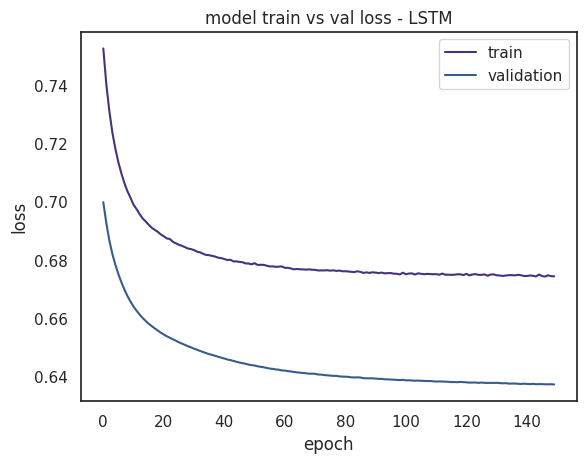

CPU times: user 36min 35s, sys: 4min 23s, total: 40min 59s
Wall time: 15min 51s


In [ ]:
%%time
if RUN_TRAINING:

    split = df_full['date_id'] > SPLIT_DAY
    df_train = df_full[~split]
    df_valid = df_full[split]

    df_train_features = build_features(df_train)
    df_valid_features = build_features(df_valid)

    scaler = StandardScaler()
    train_features = scaler.fit_transform(df_train_features)
    valid_features = scaler.transform(df_valid_features)

    train_dataset = windowed_dataset(train_features)
    valid_dataset = windowed_dataset(valid_features, shuffle=False)

    model = build_model()

    early_stopping = EarlyStopping(monitor='val_loss',
                      mode='min',
                      patience=PATIENCE,
                      restore_best_weights=True,
                      verbose=True)

    history = model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs=EPOCHS,
                        batch_size=B_SIZE,
                        callbacks=[early_stopping],
                        verbose=True)

    #Evaluate
    y_pred = model.predict(valid_dataset)

    y_pred = scaler.inverse_transform(y_pred)
    y_true = df_valid_features[LAGS:]

    mae = mean_absolute_error(y_true, y_pred)
    print(f"MAE score: {mae}")

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"RMSE score: {rmse}")

    #Plots
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs val loss - LSTM')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


In [ ]:
df_test = pd.read_csv("/kaggle/input/datareqdstkpred/test.csv/test.csv")
df_test = df_test[["stock_id", "date_id", "seconds_in_bucket", "target"]]
df_test.shape

(33000, 4)

In [ ]:

# Find the maximum stock ID
max_stock_id = df_test['stock_id'].max()

# Find the maximum date ID
max_date_id = df_test['date_id'].max()

# Find the maximum seconds in a bucket
max_seconds_in_bucket = df_test['seconds_in_bucket'].max()

print("Max Stock ID:", max_stock_id)
print("Max Date ID:", max_date_id)
print("Max Seconds in a Bucket:", max_seconds_in_bucket)


Max Stock ID: 199
Max Date ID: 480
Max Seconds in a Bucket: 540


### Feature Engineering for test set

In [ ]:
def reduce_mem_usage(df_test, verbose=0):
    start_mem = df_test.memory_usage().sum() / 1024**2

    for col in df_test.columns:
        col_type = df_test[col].dtype

        if col_type != object:
            c_min = df_test[col].min()
            c_max = df_test[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df_test[col] = df_test[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df_test[col] = df_test[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df_test[col] = df_test[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df_test[col] = df_test[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df_test[col] = df_test[col].astype(np.float16)
                else:
                    df_test[col] = df_test[col].astype(np.float32)

    print(f"Memory usage of dataframe is {start_mem:.2f} MB")
    end_mem = df_test.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f"Decreased by {decrease:.2f}%")

    return df_test

df_test = reduce_mem_usage(df_test, verbose=1)

Memory usage of dataframe is 1.01 MB
Memory usage after optimization is: 0.25 MB
Decreased by 74.99%


In [ ]:
df_test.tail()

,stock_id,date_id,seconds_in_bucket,target
32995,195,480,540,-0.510254
32996,196,480,540,2.089844
32997,197,480,540,-0.529785
32998,198,480,540,3.580078
32999,199,480,540,1.900391


In [ ]:
# Verify dimensions
print("Dimensions of df_test:", df_test.shape)
print("N_STOCKS_TEST:", N_STOCKS_TEST)
print("N_DATES_TEST:", N_DATES_TEST)
print("N_SECONDS_TEST:", N_SECONDS_TEST)

# Verify multi-index structure
print("Index structure of df_test:")
print(df_test.index)
print("Multi-index structure:")
print(multi_index)


Dimensions of df_test: (33000, 4)
N_STOCKS_TEST: 199
N_DATES_TEST: 480
N_SECONDS_TEST: 54
Index structure of df_test:
RangeIndex(start=0, stop=33000, step=1)
Multi-index structure:
MultiIndex([(  0,   0,   0),
            (  0,   0,  10),
            (  0,   0,  20),
            (  0,   0,  30),
            (  0,   0,  40),
            (  0,   0,  50),
            (  0,   0,  60),
            (  0,   0,  70),
            (  0,   0,  80),
            (  0,   0,  90),
            ...
            (199, 480, 450),
            (199, 480, 460),
            (199, 480, 470),
            (199, 480, 480),
            (199, 480, 490),
            (199, 480, 500),
            (199, 480, 510),
            (199, 480, 520),
            (199, 480, 530),
            (199, 480, 540)],
           names=['stock_id', 'date_id', 'seconds_in_bucket'], length=5291000)


In [ ]:
# # Verify dimensions
# print("Dimensions of df_test:", df_test.shape)
# print("N_STOCKS_TEST:", N_STOCKS_TEST)
# print("N_DATES_TEST:", N_DATES_TEST)
# print("N_SECONDS_TEST:", N_SECONDS_TEST)

# # Verify multi-index structure
# print("Index structure of df_test:")
# print(df_test.index)
# print("Multi-index structure:")
# print(multi_index)


Dimensions of df_test: (33000, 4)
N_STOCKS_TEST: 199
N_DATES_TEST: 480
N_SECONDS_TEST: 54
Index structure of df_test:
RangeIndex(start=0, stop=33000, step=1)
Multi-index structure:
MultiIndex([(  0,   0,   0),
            (  0,   0,  10),
            (  0,   0,  20),
            (  0,   0,  30),
            (  0,   0,  40),
            (  0,   0,  50),
            (  0,   0,  60),
            (  0,   0,  70),
            (  0,   0,  80),
            (  0,   0,  90),
            ...
            (199, 480, 450),
            (199, 480, 460),
            (199, 480, 470),
            (199, 480, 480),
            (199, 480, 490),
            (199, 480, 500),
            (199, 480, 510),
            (199, 480, 520),
            (199, 480, 530),
            (199, 480, 540)],
           names=['stock_id', 'date_id', 'seconds_in_bucket'], length=5291000)


In [ ]:
stock_ids = range(N_STOCKS_TEST)
date_ids = range(N_DATES_TEST)
seconds = [i * 10 for i in range(N_SECONDS_TEST)]

multi_index = pd.MultiIndex.from_product([stock_ids, date_ids, seconds],
                                         names=['stock_id', 'date_id', 'seconds_in_bucket'])

df_ft = df_test.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
df_ft = df_ft.fillna(0)
df_ft = df_ft.reset_index()

assert(df_ft.shape[0] == N_STOCKS_TEST * N_DATES_TEST * N_SECONDS_TEST)

df_ft

,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,0.000000
1,0,0,10,0.000000
2,0,0,20,0.000000
3,0,0,30,0.000000
4,0,0,40,0.000000
...,...,...,...,...
5158075,198,479,490,8.273438
5158076,198,479,500,9.117188
5158077,198,479,510,2.298828
5158078,198,479,520,3.279297


In [ ]:
stock_ids_test = range(N_STOCKS_TEST)
date_ids_test = range(N_DATES_TEST)
seconds = [i * 10 for i in range(N_SECONDS_TEST)]

multi_index = pd.MultiIndex.from_product([stock_ids_test, date_ids_test, seconds],
                                         names=['stock_id', 'date_id', 'seconds_in_bucket'])

df_ft = df_test.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
df_ft = df_ft.fillna(0)
df_ft = df_ft.reset_index()

assert(df_ft.shape[0] == N_STOCKS_TEST * N_DATES_TEST * N_SECONDS_TEST)

df_ft


,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,0.000000
1,0,0,10,0.000000
2,0,0,20,0.000000
3,0,0,30,0.000000
4,0,0,40,0.000000
...,...,...,...,...
5158075,198,479,490,8.273438
5158076,198,479,500,9.117188
5158077,198,479,510,2.298828
5158078,198,479,520,3.279297


In [ ]:
def build_features_test(df_test):
    all_stock_ids = range(N_STOCKS)
    all_date_ids = df_test["date_id"].unique()
    all_seconds = [i * 10 for i in range(N_SECONDS)]

    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds],
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df_ft = df_full.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_ft = df_ft.fillna(0)
    df_ft = df_ft.reset_index()

    df_pivot = df_ft.pivot_table(
                values='target',
                index=['date_id', 'seconds_in_bucket'],
                columns='stock_id')
    df_pivot = df_pivot.reset_index(drop=True)
    df_pivot.columns.name = None

    return df_pivot
build_features(df_ft)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted values after testing:
[[-0.3875   -1.869    -1.924    ... -0.02225  -1.549    -1.04    ]
 [-0.659     0.4163   -0.1475   ... -0.08167   1.007     0.2808  ]
 [-0.4026   -0.005775 -0.8677   ...  0.2195    0.714    -0.596   ]
 ...
 [-0.6343   -3.936    -2.781    ...  0.5522    0.235    -1.196   ]
 [ 0.4553    0.812     0.1731   ...  1.055     0.5703   -0.04385 ]
 [-0.8223   -0.886    -0.3591   ...  0.5034   -0.775    -0.502   ]]
Test MAE score: 5.49609375
RMSE score: 7.4609375


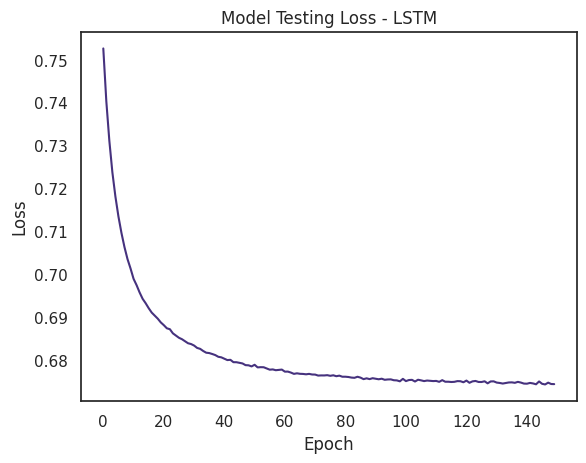

CPU times: user 908 ms, sys: 167 ms, total: 1.08 s
Wall time: 770 ms


In [ ]:
%%time
if RUN_TRAINING:



  # df_test is testing data
  df_test_features = build_features(df_test)  # Build features for testing data

  # Scale the features using the same scaler used for training data
  all_test_features = scaler.transform(df_test_features)

  # Create windowed dataset for testing data
  test_dataset = windowed_dataset(all_test_features)


  # Build the model
  # model = build_model()

  # Predict on the testing data
  y_pred_test = model.predict(test_dataset)
  y_pred_test = scaler.inverse_transform(y_pred_test)  # Inverse transform predictions
  # Print the predicted values
  print("Predicted values after testing:")
  print(y_pred_test)

  # Calculate MAE on testing data
  y_true_test = df_test_features[LAGS:]  # Access actual values from test features
  mae_test = mean_absolute_error(y_true_test, y_pred_test)

  print(f"Test MAE score: {mae_test}")
  rmse_test = mean_squared_error(y_true_test, y_pred_test, squared=False)
  print(f"RMSE score: {rmse_test}")

  # Plot training loss
  if 'loss' in history.history:
      plt.plot(history.history['loss'])
      plt.title('Model Testing Loss - LSTM')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.show()


In [ ]:
# # Reshape y_pred_test if needed
# y_pred_test_reshaped = y_pred_test.flatten()

# # Convert predicted values to DataFrame
# df_lstm_predictions = pd.DataFrame({'predicted_values_lstm': y_pred_test_reshaped})

# # Save DataFrame to CSV
# df_lstm_predictions.to_csv('/kaggle/working/predicted_values_lstm.csv', index=False)


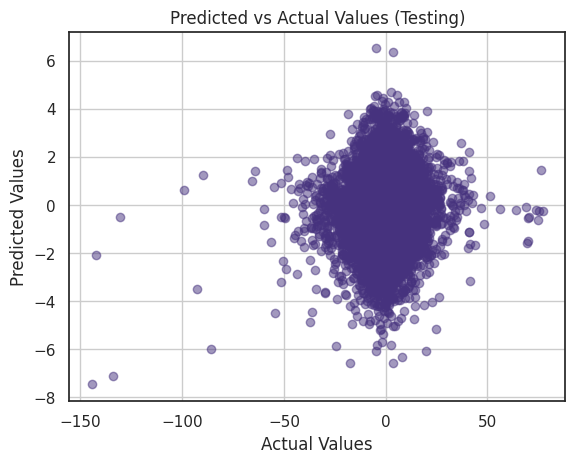

Correlation Coefficient: 0.05194151298747507


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# y_true_test and y_pred_test are actual and predicted values from testing
y_true_test_array = y_true_test.to_numpy()  # Convert DataFrame to NumPy array
y_pred_test_array = y_pred_test.flatten()  # Flatten the NumPy array

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(y_true_test_array.flatten(), y_pred_test_array)[0, 1]

# Plot predicted vs actual values
plt.scatter(y_true_test_array, y_pred_test_array, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Testing)')
plt.grid(True)
plt.show()

print(f"Correlation Coefficient: {correlation_coefficient}")


# References

CATBOOST, XGBOOST AND LGBM
https://www.kaggle.com/code/karl224/jp-explain-the-data-lightgbm-baseline
* https://xgboost.readthedocs.io/en/stable/treemethod.html
* https://catboost.ai/en/docs/features/training.
* https://lightgbm.readthedocs.io/en/latest/Features.html.
* https://www.kaggle.com/code/ravi20076/optiver-datapreparation
* https://www.kaggle.com/code/a27182818/explain-the-data-lightgbm-baseline#1.-Explore-&-Explain-the-Data

LSTM
* https://www.kaggle.com/code/dimitreoliveira/time-series-forecasting-with-lstm-autoencoders
* https://www.kaggle.com/code/bryanb/stock-prices-forecasting-with-lstm